In [1]:
# Code running experiments with different models and parameters
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from sklearn.metrics import balanced_accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from numpy import argmax
import numpy as np

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [45]:
## A separate test set is kept for consistent comparison of models (eg. its semi-supervised counterpart)

train_df = pd.read_csv('../data/processed/train.csv')
# test_df = pd.read_csv('../data/processed/test.csv')

X_train = train_df.drop(['state', 'name'], axis=1)
y_train = pd.DataFrame(train_df['state'])

# X_test = test_df.drop(['state', 'name'], axis=1)
# y_test = pd.DataFrame(test_df['state'])

In [2]:
def define_models(models=dict()):
    # nonlinear models
#     models['knn'] = KNeighborsClassifier()
#     models['cart'] = DecisionTreeClassifier()
#     models['svm'] = SVC()
    models['bayes'] = GaussianNB()
# #     models['mnb'] = MultinomialNB()
# #     models['cnb'] = ComplementNB()
#     # ensemble models
#     models['rf'] = RandomForestClassifier()
#     models['et'] = ExtraTreesClassifier()
#     models['gbm'] = GradientBoostingClassifier()
#     models['bag'] = BaggingClassifier()
    print('Defined %d models' % len(models))
    return models

# print and plot the results
def summarize_results(results, maximize=True):
    # create a list of (name, mean(scores)) tuples
    mean_scores = [(k,v) for k,v in results.items()]
    # sort tuples by mean score
    mean_scores = sorted(mean_scores, key=lambda x: x[1])
    # reverse for descending order (e.g. for accuracy)
    if maximize:
        mean_scores = list(reversed(mean_scores))
    print()
    for name, score in mean_scores:
        print('Name=%s, Score=%.3f' % (name, score))

In [3]:
models = define_models()

Defined 1 models


In [4]:
from sklearn.model_selection import LeaveOneGroupOut

def evaluate_model(trainX, trainy, testX, testy, name):
    trainy, testy = trainy[:,0], testy[:,0]
    # define the models
    models = define_models()
    model = models[name]
    # fit the model
    model.fit(trainX, trainy)
    # make predictions
    yhat = model.predict(testX)

#     hat, test = 0,0
#     for i in range(len(yhat)):
#         if yhat[i] == 0:
#             hat += 1
#         if testy[i][0] == 0:
#             test += 1
#     print('hat', hat)
#     print('test', test)
    # evaluate predictions
#     accuracy = balanced_accuracy_score(testy, yhat)
    f1_macro = f1_score(testy, yhat, average='macro')
    f1_micro = f1_score(testy, yhat, average='micro')
    f1 = f1_score(testy, yhat, average=None)

#     print('accuracy:', accuracy)
#     print(classification_report(testy, yhat))
#     print(confusion_matrix(testy, yhat))
    return f1, f1_macro, f1_micro

def run_logo(name, X_all, y_all, groups):
    logo = LeaveOneGroupOut()
    group = 0
    
    f1s = []
    f1_macros = []
    f1_micros = []
    for train_index, test_index in logo.split(X_all, groups=groups):
        group += 1
        X_train, X_test = X_all.values[train_index], X_all.values[test_index]
        y_train, y_test = y_all.values[train_index], y_all.values[test_index]
        f1, f1_macro, f1_micro = evaluate_model(X_train, y_train, X_test, y_test,name)
        f1s.append(f1)
        f1_macros.append(f1_macro)
        f1_micros.append(f1_micro)
#         print("Group {0} f1-scores: {1}".format(group, f1))
#         print(f1_macros)
#         print(f1_micros)
        
#     return np.average(f1s, axis=0).tolist()
    return np.average(f1s, axis=0).tolist(), [np.average(f1_macros).tolist()], [np.average(f1_micros).tolist()]

def evaluate_models(trainX, trainy, models, groups):
    results = dict()

    for name, model in models.items():
#         results[name] = run_logo(model, trainX, trainy, groups)
        results[name] = run_logo(name, trainX, trainy, groups)
        # show process
        print(name, results[name])
    return results

In [10]:
## Run LOGO CV for all models with no hyperparameter tuning and show f1-scores
## These results serves as a baseline


In [5]:
from os import listdir
from os import path
import re
import csv

source = '../data/processed/sklearn'
dest = 'results'
i = 1

done = ['30_15_4', '10_5_1', '5_3_2', '60_30_8', '60_90_0', '5_5_4', '30_45_23', '5_5_0', '30_30_8', '60_90_68',
        '50_100_75', '30_30_15', '60_120_90', '10_10_8', '10_20_0', '30_15_0', '60_30_23',
        '50_25_0', '50_25_6', '30_45_0', '5_10_8', '30_15_11', '30_60_30', '10_5_0', '60_60_15',
        '10_10_0', '50_100_50', '30_60_15', '60_60_0', '10_20_5', '5_10_0', '50_75_19', '10_15_11',
        '5_3_0', '30_45_11', '60_120_0', '10_20_10', '5_10_3', '10_15_0']

for name in listdir(source):
    filename = source + '/' + name
    if not name.endswith('csv') or not name.startswith('train'):
        continue
    pattern = 'train' + '[0-9]*[0-9]_[0-9]*[0-9]_[0-9]*[0-9]' + '.csv'
    match = re.search(pattern, name)
    if not match:
        continue
        
    print(i, 'out of 79 files')
    print('Reading file', name)

    train_df = pd.read_csv(filename)

    X_train = train_df.drop(['state', 'name'], axis=1)
    y_train = pd.DataFrame(train_df['state'])
    groups = train_df['name']
    
    # counting the number of samples per class
    freq = [0,0,0,0]
    for val in y_train['state']:
        freq[val] += 1
    
    print('class frequencies', freq)
    
    results = evaluate_models(X_train, y_train, models, groups)
        
    # save results and freq into file per model
    combi = re.search('train(.+?).csv', name)
    if combi:
        combi = combi.group(1)
    if combi in done:
        continue
        
#     with open(dest + '/combis', 'a+') as outFile:
#         row = [combi]
#         row.extend(freq)
#         writer = csv.writer(outFile)
#         writer.writerow(row)
    
    header = ['comb', 'f1-0', 'f1-1', 'f1-2', 'f1-3', 'macro f1', 'micro f1']

    for key in results:
        row = [combi]
        for e in results[key]:
            row.extend(e)
        
        outFilename = dest + '/' + key + '.csv'
        if not path.isfile(outFilename):
            print('creating new file', outFilename)
            with open(outFilename, 'w') as outFile:
                writer = csv.writer(outFile)
                writer.writerow(header)
                writer.writerow(row)
        else:
#         row = [combi]
#         row.extend(freq)
#         writer = csv.writer(outFile)
#         writer.writerow(row)
            print('opening existing file', outFilename)
            with open(outFilename, 'a+') as outFile:
                writer = csv.writer(outFile)
                writer.writerow(row)
    i += 1



1 out of 79 files
Reading file train30_15_4.csv
class frequencies [7527, 8556, 1307, 1350]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7405489385911024, 0.7568258056728152, 0.49630639995542, 0.5399469674619097], [0.6334070279203119], [0.7517663521678026])
1 out of 79 files
Reading file train10_5_1.csv
class frequencies [7262, 8260, 1252, 1264]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7112216987511695, 0.7392083146322354, 0.49284377835043813, 0.46219092449283683], [0.60136617905667], [0.7267335353817379])
1 out of 79 files
Reading file train5_3_2.csv
class frequencies [14494, 16500, 2524, 2556]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7000798610786642, 0.7254081455053895, 0.4515442770475049, 0.4550738441960862], [0.5830265319569112], [0.7148534711353396])
1 out of 79 files
Reading file train60_30_8.csv
class 

/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7481898894859236, 0.7797022698672053, 0.5376292863351166, 0.5296067439581732], [0.6487820474116046], [0.7623476932530181])
1 out of 79 files
Reading file train60_90_0.csv
class frequencies [2154, 2445, 369, 373]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7412096730097816, 0.7626668049684675, 0.43499185400056706, 0.5254749404223293], [0.6160858181002864], [0.7480609613290956])
1 out of 79 files
Reading file train5_5_4.csv
class frequencies [14494, 16482, 2524, 2556]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7085011475279849, 0.7239660647806576, 0.47004574304125085, 0.5025895825727834], [0.6012756344806692], [0.7232703148308255])
1 out of 79 files
Reading file train30_45_23.csv
class frequencies [3771, 4274, 650, 665]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7383894346181783, 0.7520559588540318, 0.47817085395073516, 0.5459513335716587], [0.628641895248651], [0.7529066801998572])
1 out of 79 files
Reading file train5_5_0.csv
class frequencies [2894, 3297, 521, 503]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7046040110613851, 0.730780456964527, 0.5022977145823684, 0.47305038718209835], [0.6026831424475946], [0.7231910312317104])
1 out of 79 files
Reading file train30_30_8.csv
class frequencies [3759, 4295, 649, 662]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7436286683302841, 0.7532451586620303, 0.5067840918671569, 0.5368175997764415], [0.6351188796589783], [0.7532189631968709])
1 out of 79 files
Reading file train60_90_68.csv
class frequencies [8784, 9967, 1525, 1563]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7501786744617731, 0.7610974834031232, 0.5323483741804607, 0.5675000602443089], [0.6527811480724165], [0.764618115407653])
1 out of 79 files
Reading file train50_100_75.csv
class frequencies [5804, 6574, 992, 1034]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7466405234700213, 0.7679311364210049, 0.5231239186158061, 0.5501078106032042], [0.6469508472775092], [0.763830827996032])
1 out of 79 files
Reading file train30_30_15.csv
class frequencies [5517, 6272, 970, 974]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7460875010293356, 0.7660259543608513, 0.5090061356937073, 0.5735148752750818], [0.648658616589744], [0.7593059956024454])
1 out of 79 files
Reading file train60_120_90.csv
class frequencies [6436, 7294, 1134, 1144]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7384627675145388, 0.7511763642145225, 0.5369250675837024, 0.5759952707405348], [0.6506398675133247], [0.7580259686327103])
1 out of 79 files
Reading file train10_10_8.csv
class frequencies [14483, 16477, 2512, 2580]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7262810584543908, 0.7423509220314013, 0.5176772147394004, 0.5577496450863837], [0.636014710077894], [0.7448245114932832])
1 out of 79 files
Reading file train10_20_0.csv
class frequencies [1446, 1638, 265, 256]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.709576732700937, 0.7432686585225794, 0.4721498081194423, 0.49827045548438065], [0.6058164137068349], [0.7329630025796976])
1 out of 79 files
Reading file train30_15_0.csv
class frequencies [5517, 6281, 970, 974]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7413981899342289, 0.763973356628991, 0.5043996110270492, 0.5203313151528816], [0.6325256181857877], [0.7519661014780262])
1 out of 79 files
Reading file train60_30_23.csv
class frequencies [27622, 31408, 4786, 4890]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7403863576271684, 0.7733024225401989, 0.5667899769583633, 0.5752921521926342], [0.6639427273295911], [0.7628070213076769])
1 out of 79 files
Reading file train50_25_0.csv
class frequencies [5804, 6600, 993, 1034]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7297838284775631, 0.7609942606744756, 0.5184443165947025, 0.5498692398462658], [0.639772911398252], [0.7510973920532246])
1 out of 79 files
Reading file train50_25_6.csv
class frequencies [7626, 8681, 1332, 1347]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7447242085636194, 0.7651970336166231, 0.5467411267694523, 0.5699728364025396], [0.6566588013380585], [0.7598071651800434])
1 out of 79 files
Reading file train30_45_0.csv
class frequencies [1849, 2091, 322, 316]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7340905549697551, 0.7406050907422528, 0.4265673616971186, 0.4870596195959745], [0.5970806567512752], [0.7377184094340633])
1 out of 79 files
Reading file train5_10_8.csv
class frequencies [7232, 8213, 1272, 1292]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.725232445223662, 0.7311828980493338, 0.5243183918448426, 0.5516849417255151], [0.6331046692108383], [0.741629989448393])
1 out of 79 files
Reading file train30_15_11.csv
class frequencies [20722, 23555, 3576, 3674]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7414750555109857, 0.7623630832011614, 0.5396049223563043, 0.5522451243362148], [0.6489220463511666], [0.757640964691721])
1 out of 79 files
Reading file train30_60_30.csv
class frequencies [2770, 3125, 484, 482]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7578198727433736, 0.7707557107328468, 0.5195040825000979, 0.5786834898636681], [0.6566907889599966], [0.767266965233939])
1 out of 79 files
Reading file train10_5_0.csv
class frequencies [5813, 6610, 993, 1017]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7122224848959636, 0.7445307942062585, 0.48213647072413807, 0.47738644139661385], [0.6040690478057436], [0.7295129236584253])
1 out of 79 files
Reading file train60_60_15.csv
class frequencies [4286, 4875, 758, 766]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7563988276929889, 0.7646744885085578, 0.535372788265486, 0.5853979145294153], [0.660461004749112], [0.7668191121591135])
1 out of 79 files
Reading file train10_10_0.csv
class frequencies [2903, 3283, 513, 515]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.704485074541635, 0.7358937421057973, 0.4527251131600225, 0.5237713505783079], [0.6042188200964407], [0.7281360015216891])
1 out of 79 files
Reading file train50_100_50.csv
class frequencies [2900, 3273, 513, 518]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7398902382156486, 0.746412604339715, 0.5025517673493487, 0.5716171793000746], [0.6401179473011968], [0.7518635407222134])
1 out of 79 files
Reading file train30_60_15.csv
class frequencies [1828, 2084, 330, 332]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7434042680013266, 0.7608834517332156, 0.48021440504910945, 0.5487006297528463], [0.6333006886341245], [0.7534439256231382])
1 out of 79 files
Reading file train60_60_0.csv
class frequencies [3216, 3668, 567, 565]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7391385332542031, 0.7551532082517832, 0.4907057955513292, 0.5336754587307035], [0.6296682489470048], [0.7500582390089745])
1 out of 79 files
Reading file train10_20_5.csv
class frequencies [1932, 2204, 322, 345]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.713383313218397, 0.7314576652546981, 0.48102873226330317, 0.49140185347443044], [0.6043178910527071], [0.731292275819317])
1 out of 79 files
Reading file train5_10_0.csv
class frequencies [1440, 1641, 271, 253]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7100429685650536, 0.7305611603446964, 0.5170604812937801, 0.5321683022097351], [0.6224582281033162], [0.7280147117808136])
1 out of 79 files
Reading file train50_75_19.csv
class frequencies [2582, 2926, 465, 463]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7455429071467847, 0.7647215072816969, 0.48487495668667574, 0.5065872455470388], [0.625431654165549], [0.7524147544713107])
1 out of 79 files
Reading file train10_15_11.csv
class frequencies [7232, 8222, 1272, 1292]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7262274106189601, 0.7484842742221942, 0.5195427297329333, 0.5553891926237711], [0.6374109017994646], [0.7477228210823427])
1 out of 79 files
Reading file train5_3_0.csv
class frequencies [4825, 5500, 842, 860]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7017340375882555, 0.722056149822796, 0.45678415446173204, 0.45600786949224115], [0.5841455528412562], [0.7143011527209131])
1 out of 79 files
Reading file train30_45_11.csv
class frequencies [2443, 2760, 417, 437]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7423015704303728, 0.764248933791855, 0.4958446667078707, 0.5770577335423414], [0.6448632261181099], [0.7581772337506707])
1 out of 79 files
Reading file train60_120_0.csv
class frequencies [1612, 1827, 292, 275]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7423393894003838, 0.7484632383788765, 0.5120034707039753, 0.5139434501096252], [0.6291873871482152], [0.7465678169607642])
1 out of 79 files
Reading file train10_20_10.csv
class frequencies [2903, 3274, 513, 515]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7227845507813446, 0.7501174199169128, 0.48666618447098453, 0.5266496430403237], [0.6215544495523915], [0.7427821392517022])
1 out of 79 files
Reading file train5_10_3.csv
class frequencies [2095, 2361, 344, 348]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7168707044564896, 0.7357416658071105, 0.4342509883786646, 0.5145124302056825], [0.6003439472119868], [0.7308048542558735])
1 out of 79 files
Reading file train10_15_0.csv
class frequencies [1931, 2199, 346, 334]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7141841323671712, 0.7380886315751601, 0.4687902573616859, 0.5424564468673645], [0.6158798670428455], [0.7348623524518062])
1 out of 79 files
Reading file train10_15_4.csv
class frequencies [2626, 3007, 456, 464]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7221347315059456, 0.7529711233712062, 0.48941176585362417, 0.4894677575759327], [0.6134963445766773], [0.7394598080735224])
opening existing file results/gbm.csv
2 out of 79 files
Reading file train60_60_45.csv
class frequencies [12875, 14631, 2249, 2292]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7517810867919553, 0.7671225291613132, 0.5466860955702288, 0.5882112822262575], [0.6634502484374388], [0.7675424987467597])
opening existing file results/gbm.csv
3 out of 79 files
Reading file train30_60_0.csv
class frequencies [1379, 1575, 237, 242]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7449325156419029, 0.7778313788221167, 0.4643203607574391, 0.5133927756333472], [0.6251192577137015], [0.7569023595785268])
opening existing file results/gbm.csv
4 out of 79 files
Reading file train10_10_5.csv
class frequencies [5813, 6601, 993, 1017]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7160097880200582, 0.745424368813732, 0.5110043557989348, 0.5440208175626684], [0.6291148325488485], [0.7398604235873117])
opening existing file results/gbm.csv
5 out of 79 files
Reading file train50_75_0.csv
class frequencies [1917, 2198, 348, 346]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7346068260902814, 0.7593119460032347, 0.4870805147861077, 0.5059797838859281], [0.6217447676913881], [0.7484279932494308])
opening existing file results/gbm.csv
6 out of 79 files
Reading file train30_45_34.csv
class frequencies [7533, 8559, 1304, 1320]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7419490152920271, 0.7519274043539765, 0.5213400097025427, 0.5559833265618017], [0.642799938977587], [0.757221363207842])
opening existing file results/gbm.csv
7 out of 79 files
Reading file train50_25_13.csv
class frequencies [12078, 13746, 2083, 2152]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7505919179884323, 0.7824816757696285, 0.5616619142670465, 0.576917293718488], [0.6679132004358987], [0.7694672780622348])
opening existing file results/gbm.csv
8 out of 79 files
Reading file train50_50_0.csv
class frequencies [2900, 3282, 513, 518]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7377302230678817, 0.7521089441059852, 0.4959087379319265, 0.5661739835935422], [0.6379804721748338], [0.7477888374569326])
opening existing file results/gbm.csv
9 out of 79 files
Reading file train10_5_3.csv
class frequencies [14494, 16500, 2524, 2556]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.713641981135747, 0.7499051675916466, 0.49520996589106253, 0.5007840605632025], [0.6148852937954147], [0.7331024228235266])
opening existing file results/gbm.csv
10 out of 79 files
Reading file train30_30_22.csv
class frequencies [10348, 11764, 1799, 1839]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7404780920282651, 0.7616805563737663, 0.5308982953596577, 0.5618602925636753], [0.6487293090813412], [0.7584964184921232])
opening existing file results/gbm.csv
11 out of 79 files
Reading file train60_90_45.csv
class frequencies [4302, 4881, 744, 752]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.741609474755982, 0.7571157436433316, 0.47798742120368803, 0.5486721748949358], [0.6313462036244843], [0.7540226447147446])
opening existing file results/gbm.csv
12 out of 79 files
Reading file train60_30_0.csv
class frequencies [6436, 7321, 1134, 1144]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7357496169439229, 0.7662578414053552, 0.5267244500084882, 0.540947033454827], [0.6424197354531482], [0.7533287851191499])
opening existing file results/gbm.csv
13 out of 79 files
Reading file train10_5_4.csv
class frequencies [28977, 32995, 5036, 5136]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7175392001779284, 0.7477625940878418, 0.5117900671981827, 0.5148219582708807], [0.6229784549337084], [0.7365490768676352])
opening existing file results/gbm.csv
14 out of 79 files
Reading file train30_15_8.csv
class frequencies [11825, 13460, 2052, 2107]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7407272261222687, 0.761713481324882, 0.5364367981957693, 0.5607979731568556], [0.6499188696999

/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7470034557777154, 0.7745156607128826, 0.5533002693227109, 0.5603852144101666], [0.6588011500558689], [0.7630291336758352])
opening existing file results/gbm.csv
16 out of 79 files
Reading file train60_120_60.csv
class frequencies [3216, 3659, 567, 565]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7392663276786681, 0.7608900966154688, 0.4999442464668235, 0.5498102783074068], [0.6374777372670918], [0.756494643796961])
opening existing file results/gbm.csv
17 out of 79 files
Reading file train50_25_19.csv
class frequencies [24157, 27482, 4176, 4300]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.743166688229345, 0.7632004017572542, 0.5698387453036295, 0.5917674090748024], [0.6669933110912578], [0.7632708475236756])
opening existing file results/gbm.csv
18 out of 79 files
Reading file train5_8_0.csv
class frequencies [1804, 2061, 323, 320]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7123238838095518, 0.7318561481779734, 0.4724678617810139, 0.5335682773517652], [0.6125540427800761], [0.7281816112048668])
opening existing file results/gbm.csv
19 out of 79 files
Reading file train5_5_1.csv
class frequencies [3631, 4124, 621, 642]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7014610291918767, 0.7301502048431945, 0.4332206523214656, 0.4979751484212785], [0.5907017586944538], [0.7

/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7169370271079719, 0.7457881058342117, 0.48847876076205565, 0.5569644631935042], [0.6270420892244358], [0.7412480805564357])
opening existing file results/gbm.csv
22 out of 79 files
Reading file train50_50_13.csv
class frequencies [3908, 4453, 679, 705]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7479940747507836, 0.756933576884499, 0.5082539814669118, 0.521370895721842], [0.6336381322060092], [0.755224499132357])
opening existing file results/gbm.csv
23 out of 79 files
Reading file train50_50_25.csv
class frequencies [5804, 6591, 993, 1034]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7363625423132579, 0.7529430222399554, 0.5222231576636909, 0.5451520828895848], [0.6391702012766224], [0.7537895420799363])
opening existing file results/gbm.csv
24 out of 79 files
Reading file train5_8_2.csv
class frequencies [2406, 2742, 422, 439]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7197569272831474, 0.725908955769777, 0.519565941913908, 0.5300407429594404], [0.6238181419815682], [0.7329204306163414])
opening existing file results/gbm.csv
25 out of 79 files
Reading file train50_75_38.csv
class frequencies [3911, 4451, 689, 689]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7336796713590041, 0.7531566570587429, 0.5075081660329156, 0.5296083217520372], [0.6309882040506749], [0.7539007242849881])
opening existing file results/gbm.csv
26 out of 79 files
Reading file train60_120_30.csv
class frequencies [2151, 2433, 376, 380]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7555834784053789, 0.7662160756325975, 0.4793196263574953, 0.5386984041538073], [0.6349543961373197], [0.7611667612290062])
opening existing file results/gbm.csv
27 out of 79 files
Reading file train5_10_5.csv
class frequencies [2894, 3288, 521, 503]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7091575361945724, 0.7309185745403539, 0.5258940218851496, 0.49413484424960885], [0.6150262442174211], [0.7302580486570088])
opening existing file results/gbm.csv
28 out of 79 files
Reading file train10_10_3.csv
class frequencies [4130, 4709, 731, 733]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7150464410551693, 0.7464240040139853, 0.4837244404790322, 0.4884231808581964], [0.6084045166015959], [0.7348485832880676])
opening existing file results/gbm.csv
29 out of 79 files
Reading file train5_3_1.csv
class frequencies [7262, 8260, 1252, 1264]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.6944393104458347, 0.7342030804687678, 0.4535918094857444, 0.4146617830176463], [0.5742239958544982], [0.7117241711587025])
opening existing file results/gbm.csv
30 out of 79 files
Reading file train30_30_0.csv
class frequencies [2770, 3134, 484, 482]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.74152265613701, 0.7597408426035424, 0.5065525467552161, 0.5932370136101088], [0.6502632647764693], [0.7559842006468565])
opening existing file results/gbm.csv
31 out of 79 files
Reading file train50_50_38.csv
class frequencies [12080, 13726, 2087, 2148]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7382944581437194, 0.7605561297328263, 0.5452207976775927, 0.5594910708049866], [0.6508906140897812], [0.7604815678050766])
opening existing file results/gbm.csv
32 out of 79 files
Reading file train60_90_23.csv
class frequencies [2877, 3283, 512, 503]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7404550884887664, 0.7515981811387179, 0.4902707825170315, 0.5664327447240585], [0.6371891992171437], [0.7540676926750716])
opening existing file results/gbm.csv
33 out of 79 files
Reading file train5_5_3.csv
class frequencies [7262, 8251, 1252, 1264]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7097680566067307, 0.7240593176100852, 0.47214547169080073, 0.4795645374910371], [0.5963843458496635], [0.721902661803581])
opening existing file results/gbm.csv
34 out of 79 files
Reading file train5_8_6.csv
class frequencies [7232, 8222, 1272, 1292]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7177303297513823, 0.7286318232755927, 0.5060933355982475, 0.5383873935919423], [0.6227107205542911], [0.734878758565587])
opening existing file results/gbm.csv
35 out of 79 files
Reading file train10_20_15.csv
class frequencies [5813, 6583, 993, 1017]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7207531473138337, 0.7497643463123898, 0.5175837319168086, 0.5375919001836029], [0.6314232814316587], [0.7475141309225045])
opening existing file results/gbm.csv
36 out of 79 files
Reading file train50_100_25.csv
class frequencies [1939, 2191, 322, 350]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.747353593473301, 0.7600791621242886, 0.5217083726762347, 0.550872674896185], [0.6450034507925023], [0.7599933687015772])
opening existing file results/gbm.csv
37 out of 79 files
Reading file train30_60_45.csv
class frequencies [5517, 6255, 969, 974]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7568147776889984, 0.770576998200361, 0.5262294799179998, 0.5889347201012999], [0.6606389939771647], [0.769224739470794])
opening existing file results/gbm.csv
38 out of 79 files
Reading file train50_75_56.csv
class frequencies [7632, 8668, 1322, 1342]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7520232412546531, 0.7744489355404353, 0.5684979401982759, 0.5615506875858666], [0.6641302011448077], [0.7712043911091829])
opening existing file results/gbm.csv
39 out of 79 files
Reading file train5_8_4.csv
class frequencies [3615, 4113, 645, 637]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.7101746021688045, 0.7195456005926437, 0.5079670093017778, 0.5207477074855947], [0.614608729887205], [0.7297240725583076])
opening existing file results/gbm.csv
40 out of 79 files
Reading file train60_60_30.csv
class frequencies [6436, 7312, 1134, 1144]
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Defined 1 models
Defined 1 models
Defined 1 models
Defined 1 models
gbm ([0.738075971936053, 0.7545111495812145, 0.5288982762668147, 0.5975924246109174], [0.6547694555987499], [0.7563033390325895])
opening existing file results/gbm.csv


In [2]:
# experiments keras neural network models
from numpy import mean
from numpy import std
from numpy import dstack
import numpy as np
from pandas import read_csv
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from keras.utils import to_categorical
from keras.layers import Bidirectional

from matplotlib import pyplot

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Using TensorFlow backend.


In [3]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    print('loaded', len(loaded[0]))
#     print('loaded', loaded)
    loaded = dstack(loaded)
    print('stacked', loaded.shape)
#     print('stacked', loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, comb, prefix=''):
#     filepath = prefix + group + '/keras/'
    prefix = prefix + group + '/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'_'+comb+'.csv', 'total_acc_y_'+group+'_'+comb+'.csv', 'total_acc_z_'+group+'_'+comb+'.csv']
    # load input data
    X = load_group(filenames, prefix)
    # load class output
    y = load_file(prefix + 'state_'+group+'_'+comb+'.csv')
    path = prefix + 'subjects_' + group + '_' +comb+'.csv'
    print(path)
    subjects = read_csv(path, header=None)
    print('done')
    return X, y, subjects

# load the dataset, returns train and test X and y elements
def load_dataset(comb,  prefix=''):
    # load all train
    trainX, trainy, subjects = load_dataset_group('train', comb, prefix)
    print(trainX.shape, trainy.shape)
    # load all test
    testX, testy, subjects = load_dataset_group('test', comb, prefix)
#     print(testX.shape, testy.shape)
    # zero-offset class values
#     trainy = trainy - 1
#     testy = testy - 1
    # one hot encode y
#     trainy = to_categorical(trainy)
#     y_true = testy
#     testy = to_categorical(testy)
#     print(trainX.shape, trainy.shape)
    return trainX, trainy, testX, testy, subjects

# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))
    

In [4]:
# Define two neural networks: MLP and LSTM

def define_nns(n_timesteps, n_features, n_outputs, models=dict()):    
    mlp = Sequential()
    mlp.add(Dense(n_features, input_shape=(n_timesteps,n_features), activation='relu'))
#     mlp.add(Dropout(0.5))
#     mlp.add(Dense(100, activation='relu'))
    mlp.add(Flatten())
    mlp.add(Dense(4, activation='softmax'))
    mlp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
    models['fnn'] = mlp
    
    lstm = Sequential()
    lstm.add(LSTM(n_features, input_shape=(n_timesteps,n_features), activation='relu'))
#     lstm.add(Dropout(0.5))
#     lstm.add(Dense(100, activation='relu'))
    lstm.add(Dense(n_outputs, activation='softmax'))
    lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
    models['lstm'] = lstm
    
    return models


In [5]:
from sklearn.model_selection import LeaveOneGroupOut

def evaluate_model(trainX, trainy, testX, testy, y_true, model):
    verbose, epochs = 1, 10
#     trainy, testy = trainy[:,0], testy[:,0]
    # fit the model
    model.fit(trainX, trainy, epochs=epochs, verbose=verbose)
#     # make predictions
    yhat = model.predict_classes(testX)
#     print('yhat', yhat)
    f1_macro = f1_score(y_true, yhat, average='macro')
    f1_micro = f1_score(y_true, yhat, average='micro')
    f1 = f1_score(y_true, yhat, average=None)
    _, accuracy = model.evaluate(testX, testy, verbose=verbose)

#     _, accuracy = model.evaluate(testX, y_true, batch_size=batch_size, verbose=verbose)
#     print('accuracy:', accuracy)
#     print(classification_report(testy, yhat))
#     print(confusion_matrix(testy, yhat))
#     print(accuracy)
    return f1, f1_macro, f1_micro
#     return 0,0,0

def run_logo(X_all, y_all, groups, X_dummy):
    print(len(X_all))
    print(len(y_all))
    print(len(groups))
    logo = LeaveOneGroupOut()
    group = 0
    
    f1s = []
    f1_macros = []
    f1_micros = []

    results = []
    for train_indices, test_indices in logo.split(X_dummy, groups=groups[0:len(X_all)]):
        group += 1
        
        X_train, X_test = X_all[train_indices], X_all[test_indices]
        y_train, y_test = y_all[train_indices], y_all[test_indices]
        y_train = to_categorical(y_train)
        y_true = y_test
        y_test = to_categorical(y_test)

        key = 'lstm'
#         n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], to_categorical(trainy).shape[1]
        models = define_nns(n_timesteps=X_train.shape[1], n_features=X_train.shape[2], n_outputs=y_train.shape[1])
        f1, f1_macro, f1_micro = evaluate_model(X_train, y_train, X_test, y_test, y_true, models[key])
#         accuracy = evaluate_model(X_train, y_train, X_test, y_test, y_true, models['mlp'])
        f1s.append(f1)
        f1_macros.append(f1_macro)
        f1_micros.append(f1_micro)
#         print("Group {0} f1-scores: {1}".format(group, f1))
# #         print(f1_macros)
# #         print(f1_micros)
        
# #     return np.average(f1s, axis=0).tolist()
#         verbose, epochs, batch_size = 1, 100, 10
#         print('prefit')
#         clf.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
#         clf.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
#         print('fit')
#         _, accuracy = clf.evaluate(X_test, y_test, batch_size=batch_size, verbose=verbose)
# #         _, accuracy = clf.evaluate(X_test, y_test, batch_size=batch_size, verbose=verbose)
#         print('accuracy', accuracy)
#         results.append(accuracy)
#     return np.average(results)
    return {key: (np.average(f1s, axis=0).tolist(), [np.average(f1_macros).tolist()], [np.average(f1_micros).tolist()])}


# result = run_logo(model, trainX, trainy, subjects.iloc[:,0], X_dummy)
# print(result)


In [6]:
from os import listdir
from os import path
import re
import csv

source = '../data/processed/train/keras/'
dest = 'results'
i = 1

for name in listdir(source):
    filename = source + '/' + name
    if not name.endswith('csv') or not name.startswith('total_acc_x_train_'):
        continue
    pattern = 'total_acc_x_train_' + '[0-9]*[0-9]_[0-9]*[0-9]_[0-9]*[0-9]' + '.csv'
    match = re.search(pattern, name)
    if not match:
        continue

    combi = re.search('train_(.+?).csv', name)
    if combi:
        combi = combi.group(1)
    
    trainX, trainy, subjects = load_dataset(comb=combi, prefix=source)
    # dummy dataset just for logo.split
    X_dummy = np.arange(len(trainX))
    
    results = run_logo(trainX, trainy, subjects.iloc[:,0], X_dummy)

    header = ['comb', 'f1-0', 'f1-1', 'f1-2', 'f1-2', 'macro f1', 'micro f1']
    
    for key in results:
        row = [combi]
        for e in results[key]:
            row.extend(e)
        
        outFilename = dest + '/' + key + '.csv'
        if not path.isfile(outFilename):
            print('creating new file', outFilename)
            with open(outFilename, 'w') as outFile:
                writer = csv.writer(outFile)
                writer.writerow(header)
                writer.writerow(row)
                outFile.close()
        else:
#         row = [combi]
#         row.extend(freq)
#         writer = csv.writer(outFile)
#         writer.writerow(row)
            print('opening existing file', outFilename)
            with open(outFilename, 'a+') as outFile:
                writer = csv.writer(outFile)
                writer.writerow(row)
                outFile.close()
    i += 1


loaded 32072
stacked (32072, 60, 3)
../data/processed/train/keras/subjects_train_60_60_45.csv
done
(32072, 60, 3) (32072, 1)
32072
32072
32072


W0716 15:55:02.399233 139887819667200 deprecation.py:323] From /home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/tensorflow_core/python/ops/math_grad.py:1251: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 26651 samples
Epoch 1/10
26651/26651 [==============================] - 10s 370us/sample - loss: 1.2464 - categorical_accuracy: 0.4145
Epoch 2/10
26651/26651 [==============================] - 9s 354us/sample - loss: 1.1201 - categorical_accuracy: 0.4433
Epoch 3/10
26651/26651 [==============================] - 9s 354us/sample - loss: 1.1013 - categorical_accuracy: 0.4444
Epoch 4/10
26651/26651 [==============================] - 9s 353us/sample - loss: 1.0776 - categorical_accuracy: 0.5473
Epoch 5/10
26651/26651 [==============================] - 9s 352us/sample - loss: 1.0304 - categorical_accuracy: 0.6306
Epoch 6/10
26651/26651 [==============================] - 10s 367us/sample - loss: 0.9871 - categorical_accuracy: 0.6562
Epoch 7/10
26651/26651 [==============================] - 10s 373us/sample - loss: 0.9652 - categorical_accuracy: 0.6523
Epoch 8/10
26651/26651 [==============================] - 10s 371us/sample - loss: 0.9489 - categorical_accuracy: 0.6556
Epoch 9/10
26

/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


5421/5421 [==============================] - 1s 224us/sample - loss: 0.7845 - categorical_accuracy: 0.7761
Train on 28587 samples
Epoch 1/10
28587/28587 [==============================] - 11s 387us/sample - loss: 1.1278 - categorical_accuracy: 0.4433
Epoch 2/10
28587/28587 [==============================] - 11s 369us/sample - loss: 1.0907 - categorical_accuracy: 0.4581
Epoch 3/10
28587/28587 [==============================] - 11s 370us/sample - loss: 1.0879 - categorical_accuracy: 0.4606
Epoch 4/10
28587/28587 [==============================] - 11s 368us/sample - loss: 1.0723 - categorical_accuracy: 0.5114
Epoch 5/10
28587/28587 [==============================] - 11s 369us/sample - loss: 0.9939 - categorical_accuracy: 0.6314
Epoch 6/10
28587/28587 [==============================] - 11s 370us/sample - loss: 0.9251 - categorical_accuracy: 0.6825
Epoch 7/10
28587/28587 [==============================] - 11s 369us/sample - loss: 0.9025 - categorical_accuracy: 0.6888
Epoch 8/10
28587/28587 

/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1807/1807 [==============================] - 1s 362us/sample - loss: 1.0528 - categorical_accuracy: 0.5208
Train on 9529 samples
Epoch 1/10
9529/9529 [==============================] - 5s 542us/sample - loss: 1.2183 - categorical_accuracy: 0.4125
Epoch 2/10
9529/9529 [==============================] - 5s 501us/sample - loss: 1.0993 - categorical_accuracy: 0.4570
Epoch 3/10
9529/9529 [==============================] - 5s 498us/sample - loss: 1.0916 - categorical_accuracy: 0.4569
Epoch 4/10
9529/9529 [==============================] - 5s 499us/sample - loss: 1.0889 - categorical_accuracy: 0.4573
Epoch 5/10
9529/9529 [==============================] - 5s 499us/sample - loss: 1.0840 - categorical_accuracy: 0.4885
Epoch 6/10
9529/9529 [==============================] - 5s 499us/sample - loss: 1.0892 - categorical_accuracy: 0.4758
Epoch 7/10
9529/9529 [==============================] - 5s 501us/sample - loss: 1.0909 - categorical_accuracy: 0.4765
Epoch 8/10
9529/9529 [=======================

/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


2439/2439 [==============================] - 1s 223us/sample - loss: 1.0538 - categorical_accuracy: 0.5244
Train on 12865 samples
Epoch 1/10
12865/12865 [==============================] - 4s 322us/sample - loss: 1.2922 - categorical_accuracy: 0.4141
Epoch 2/10
12865/12865 [==============================] - 4s 294us/sample - loss: 1.1644 - categorical_accuracy: 0.4574
Epoch 3/10
12865/12865 [==============================] - 4s 295us/sample - loss: 1.1186 - categorical_accuracy: 0.4574
Epoch 4/10
12865/12865 [==============================] - 4s 295us/sample - loss: 1.1025 - categorical_accuracy: 0.4574
Epoch 5/10
12865/12865 [==============================] - 4s 296us/sample - loss: 1.0952 - categorical_accuracy: 0.4573
Epoch 6/10
12865/12865 [==============================] - 4s 296us/sample - loss: 1.0883 - categorical_accuracy: 0.4574
Epoch 7/10
12865/12865 [==============================] - 4s 295us/sample - loss: 1.0774 - categorical_accuracy: 0.4575
Epoch 8/10
12865/12865 [======

/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


3168/3168 [==============================] - 1s 165us/sample - loss: 0.8724 - categorical_accuracy: 0.6222
Train on 16703 samples
Epoch 1/10
16703/16703 [==============================] - 5s 293us/sample - loss: 1.1923 - categorical_accuracy: 0.3914
Epoch 2/10
16703/16703 [==============================] - 5s 273us/sample - loss: 1.0855 - categorical_accuracy: 0.4700
Epoch 3/10
16703/16703 [==============================] - 5s 273us/sample - loss: 1.0143 - categorical_accuracy: 0.6277
Epoch 4/10
16703/16703 [==============================] - 5s 274us/sample - loss: 0.9644 - categorical_accuracy: 0.6562
Epoch 5/10
16703/16703 [==============================] - 5s 273us/sample - loss: 0.9409 - categorical_accuracy: 0.6674
Epoch 6/10
16703/16703 [==============================] - 4s 258us/sample - loss: 0.9299 - categorical_accuracy: 0.6693
Epoch 7/10
16703/16703 [==============================] - 4s 259us/sample - loss: 0.9182 - categorical_accuracy: 0.6790
Epoch 8/10
16703/16703 [======

In [19]:
# GridSearchCV with the best combination for all algorithms
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV

def evaluate_model(trainX, trainy, testX, testy, model):
    trainy, testy = trainy[:,0], testy[:,0]

    # fit the model
    model.fit(trainX, trainy)
    # make predictions
    yhat = model.predict(testX)

#     hat, test = 0,0
#     for i in range(len(yhat)):
#         if yhat[i] == 0:
#             hat += 1
#         if testy[i][0] == 0:
#             test += 1
#     print('hat', hat)
#     print('test', test)
    # evaluate predictions
#     accuracy = balanced_accuracy_score(testy, yhat)
    f1_macro = f1_score(testy, yhat, average='macro')
    f1_micro = f1_score(testy, yhat, average='micro')
    f1 = f1_score(testy, yhat, average=None)

#     print('accuracy:', accuracy)
#     print(classification_report(testy, yhat))
#     print(confusion_matrix(testy, yhat))
    return f1, f1_macro, f1_micro, model

def run_nested_logo(X_all, y_all, all_df, groups):
    logo = LeaveOneGroupOut()
    group = 0

    f1s = []
    f1_macros = []
    f1_micros = []
    best_params = []
    best_scores = []

#     clf = RandomForestClassifier()
#     params = {'n_estimators': [10, 100, 200],
#                'max_depth': [None, 50, 80],
#                'min_samples_leaf': [1, 5],
#                'min_samples_split': [2, 8, 10],
#                'max_features': ['log2', 'sqrt','auto', None], 
#                'criterion': ['entropy', 'gini']}
#     for train_index, test_index in logo.split(X_all, groups=groups):
#         X_train, X_test = X_all.values[train_index], X_all.values[test_index]
#         y_train, y_test = y_all.values[train_index], y_all.values[test_index]
        
#         inner_groups = all_df.iloc[all_df.index.isin(train_index)]['name']

#         grid_obj = GridSearchCV(clf, params, scoring='f1_macro', cv=logo.split(X_train, groups=inner_groups), n_jobs=-1)
#         f1, f1_macro, f1_micro, grid_obj = evaluate_model(X_train, y_train, X_test, y_test, grid_obj)
#         print('Group', group)
#         print(best_params_)
#         print(best_score_)
#         best_params.append(grid_obj.best_params_)
#         best_scores.append(grid_obj.best_score_)
#         group += 1
        
    grid_obj = GridSearchCV(clf, params, scoring='f1_macro', cv=logo.split(X_all, groups=groups), n_jobs=-1)
#     f1, f1_macro, f1_micro, grid_obj = evaluate_model(X_all, y_all, X_test, y_test, grid_obj)
    grid_obj.fit(X_all, y_all)
    
    print('best params', best_params_)
    print('best score', best_score_)

#     return np.average(f1s, axis=0).tolist(), [np.average(f1_macros).tolist()], [np.average(f1_micros).tolist()], best_params, best_scores
    return 0

In [20]:
train_df = pd.read_csv('../data/processed/sklearn/train50_50_38.csv')
X_all = train_df.drop(['state', 'name'], axis=1)
y_all = pd.DataFrame(train_df['state'])
groups = train_df['name']

results = run_nested_logo(X_all, y_all, train_df, groups)

KeyboardInterrupt: 

In [14]:
# Code running experiments with different models and parameters
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from sklearn.metrics import balanced_accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from numpy import argmax
import numpy as np

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# GridSearchCV results for all algorithms
# GridSearchCV with the best combination for all algorithms
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV

train_df = pd.read_csv('../data/processed/train.csv')
test_df = pd.read_csv('../data/processed/test.csv')

X_train = train_df.drop(['state', 'name'], axis=1)
y_train = pd.DataFrame(train_df['state'])

X_test = test_df.drop(['state', 'name'], axis=1)
y_test = pd.DataFrame(test_df['state'])

groups = train_df['name']

def evaluate_model(trainX, trainy, testX, testy, model):
    trainy, testy = trainy[:,0], testy[:,0]

    # fit the model
    model.fit(trainX, trainy)
    # make predictions
    yhat = model.predict(testX)

#     hat, test = 0,0
#     for i in range(len(yhat)):
#         if yhat[i] == 0:
#             hat += 1
#         if testy[i][0] == 0:
#             test += 1
#     print('hat', hat)
#     print('test', test)
    # evaluate predictions
#     accuracy = balanced_accuracy_score(testy, yhat)
    f1_macro = f1_score(testy, yhat, average='macro')
    f1_micro = f1_score(testy, yhat, average='micro')
    f1 = f1_score(testy, yhat, average=None)

#     print('accuracy:', accuracy)
#     print(classification_report(testy, yhat))
#     print(confusion_matrix(testy, yhat))
    return f1, f1_macro, f1_micro, model

logo = LeaveOneGroupOut()
clf = RandomForestClassifier()
params = {'n_estimators': [10, 100, 200],
           'max_depth': [None, 50, 80],
           'min_samples_leaf': [1, 5],
           'min_samples_split': [2, 8, 10],
           'max_features': ['log2', 'sqrt','auto', None], 
           'criterion': ['entropy', 'gini']}

grid_obj = GridSearchCV(clf, params, scoring='f1_macro', cv=logo.split(X_train, groups=groups), n_jobs=1)
# grid_obj.fit(X_train, y_train)
# f1, f1_macro, f1_micro, grid_obj = evaluate_model(X_train, y_train, X_test, y_test, grid_obj)

print(grid_obj.best_params_)
print(grid_obj.best_score_)


AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [43]:
source = '../data/processed/'
trainX, trainy, testX, testy, subjects = load_dataset(comb='50_50_40', prefix=source)
trainy = to_categorical(trainy)
y_true = testy
testy = to_categorical(testy)
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

# lstm = Sequential()
# lstm.add(LSTM(100, input_shape=(n_timesteps,n_features)))
# lstm.add(Dropout(0.5))
# lstm.add(Dense(50, activation='relu'))
# lstm.add(Dense(n_outputs, activation='softmax'))
# lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

mlp = Sequential()
mlp.add(Dense(50, input_shape=(n_timesteps,n_features)))
mlp.add(Dropout(0.5))
mlp.add(Dense(50, activation='relu'))
mlp.add(Flatten())
mlp.add(Dense(n_outputs, activation='softmax'))
mlp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

verbose, epochs, batch_size = 1, 20, 10
mlp.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
# evaluate model
_, accuracy = mlp.evaluate(testX, testy, batch_size=batch_size, verbose=1)
prediction = mlp.predict_classes(testX)

loaded 34954
stacked (34954, 50, 3)
../data/processed/train/subjects_train_50_50_40.csv
done
(34954, 50, 3) (34954, 1)
loaded 1117
stacked (1117, 50, 3)
../data/processed/test/subjects_test_50_50_40.csv
done
Train on 34954 samples
Epoch 1/20
34954/34954 [==============================] - 8s 242us/sample - loss: 0.8997 - categorical_accuracy: 0.6176
Epoch 2/20
34954/34954 [==============================] - 9s 246us/sample - loss: 0.5801 - categorical_accuracy: 0.7670
Epoch 3/20
34954/34954 [==============================] - 8s 222us/sample - loss: 0.5338 - categorical_accuracy: 0.8018
Epoch 4/20
34954/34954 [==============================] - 8s 217us/sample - loss: 0.5068 - categorical_accuracy: 0.8269
Epoch 5/20
34954/34954 [==============================] - 7s 205us/sample - loss: 0.4739 - categorical_accuracy: 0.8442
Epoch 6/20
34954/34954 [==============================] - 7s 210us/sample - loss: 0.4487 - categorical_accuracy: 0.8551
Epoch 7/20
34954/34954 [=========================

In [44]:
print(classification_report(y_true, prediction))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       389
           1       0.98      0.93      0.96       633
           2       0.50      0.75      0.60        53
           3       0.35      0.45      0.40        42

    accuracy                           0.91      1117
   macro avg       0.70      0.77      0.73      1117
weighted avg       0.93      0.91      0.92      1117



In [2]:
# Code running experiments with different models and parameters
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from sklearn.metrics import balanced_accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from numpy import argmax
import numpy as np

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# GridSearchCV results for all algorithms
# GridSearchCV with the best combination for all algorithms
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV

def evaluate_model(trainX, trainy, testX, testy, model):
    trainy, testy = trainy[:,0], testy[:,0]

    # fit the model
#     model.fit(trainX, trainy)
    # make predictions
    yhat = model.predict(testX)

#     hat, test = 0,0
#     for i in range(len(yhat)):
#         if yhat[i] == 0:
#             hat += 1
#         if testy[i][0] == 0:
#             test += 1
#     print('hat', hat)
#     print('test', test)
    # evaluate predictions
#     accuracy = balanced_accuracy_score(testy, yhat)
    f1_macro = f1_score(testy, yhat, average='macro')
    f1_micro = f1_score(testy, yhat, average='micro')
    f1 = f1_score(testy, yhat, average=None)

#     print('accuracy:', accuracy)
#     print(classification_report(testy, yhat))
#     print(confusion_matrix(testy, yhat))
    return f1, f1_macro, f1_micro, model

def run_nested_logo(X_all, y_all, all_df, groups):
    logo = LeaveOneGroupOut()
    group = 0

    f1s = []
    f1_macros = []
    f1_micros = []
    best_params = []
    best_scores = []

    clf = GradientBoostingClassifier()
    params = {'n_estimators': [300],
              'learning_rate': [0.1],
              'min_samples_split': [2],
              'max_features': ['auto'],
              'min_samples_leaf': [10]}
#               'max_samples': [1, 5, 10],
#               'max_features': [50, 100]}
#               'oob_score': [False, True]}
#                'bootstrap': [True, False],
#                'max_depth': [50],
#                'min_samples_split': [2],
#                'max_features': ['log2'], 
#                'criterion': ['gini']}
    for train_index, test_index in logo.split(X_all, groups=groups):
        group += 1
        X_train, X_test = X_all.values[train_index], X_all.values[test_index]
        y_train, y_test = y_all.values[train_index], y_all.values[test_index]
        
        inner_groups = all_df.iloc[all_df.index.isin(train_index)]['name']

        grid_obj = GridSearchCV(clf, params, scoring='f1_macro', cv=logo.split(X_train, groups=inner_groups), n_jobs=-1)
        f1, f1_macro, f1_micro, grid_obj = evaluate_model(X_train, y_train, X_test, y_test, grid_obj.best_estimator_)
        best_params.append(grid_obj.best_params_)
        best_scores.append(grid_obj.best_score_)
    group += 1
        
    print(best_params)
    print(best_scores)
    return grid_obj, best_params, best_scores

In [17]:
import pandas as pd

train_df = pd.read_csv('../data/processed/sklearn/train50_25_13.csv')
X_all = train_df.drop(['state', 'name'], axis=1)
y_all = pd.DataFrame(train_df['state'])
groups = train_df['name']

results = run_nested_logo(X_all, y_all, train_df, groups)

/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequ

[{'min_samples_leaf': 10, 'n_estimators': 300, 'min_samples_split': 2, 'learning_rate': 0.1, 'max_features': 'auto'}, {'min_samples_leaf': 10, 'n_estimators': 300, 'min_samples_split': 2, 'learning_rate': 0.1, 'max_features': 'auto'}, {'min_samples_leaf': 10, 'n_estimators': 300, 'min_samples_split': 2, 'learning_rate': 0.1, 'max_features': 'auto'}, {'min_samples_leaf': 10, 'n_estimators': 300, 'min_samples_split': 2, 'learning_rate': 0.1, 'max_features': 'auto'}, {'min_samples_leaf': 10, 'n_estimators': 300, 'min_samples_split': 2, 'learning_rate': 0.1, 'max_features': 'auto'}, {'min_samples_leaf': 10, 'n_estimators': 300, 'min_samples_split': 2, 'learning_rate': 0.1, 'max_features': 'auto'}, {'min_samples_leaf': 10, 'n_estimators': 300, 'min_samples_split': 2, 'learning_rate': 0.1, 'max_features': 'auto'}, {'min_samples_leaf': 10, 'n_estimators': 300, 'min_samples_split': 2, 'learning_rate': 0.1, 'max_features': 'auto'}, {'min_samples_leaf': 10, 'n_estimators': 300, 'min_samples_spli

In [ ]:
## Correct way to do nested LOOCV
# nested LOOCV with the all combis and hyperparameter tuning
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from os import listdir
from os import path
import re
import csv

def evaluate_model(trainX, trainy, testX, testy, model):
    trainy, testy = trainy[:,0], testy[:,0]

    # fit the model
    model.fit(trainX, trainy)
    # make predictions
    yhat = model.predict(testX)

#     hat, test = 0,0
#     for i in range(len(yhat)):
#         if yhat[i] == 0:
#             hat += 1
#         if testy[i][0] == 0:
#             test += 1
#     print('hat', hat)
#     print('test', test)
    # evaluate predictions
#     accuracy = balanced_accuracy_score(testy, yhat)
    f1_macro = f1_score(testy, yhat, average='macro')
    f1 = f1_score(testy, yhat, average=None)

#     print('accuracy:', accuracy)
#     print(classification_report(testy, yhat))
#     print(confusion_matrix(testy, yhat))
    return f1, f1_macro, model

def run_nested_logo(source, dest, key):
    logo = LeaveOneGroupOut()

    i = 1
    
    done = ['30_15_4', '10_5_1', '5_3_2', '60_30_8', '60_90_0', '5_5_4', '30_45_23',
        '5_5_0', '30_30_8', '60_90_68', '50_100_75', '30_30_15', '60_120_90',
        '10_10_8', '10_20_0', '30_15_0', '60_30_23', '50_25_0', '50_25_6', '30_45_0',
        '5_10_8', '30_15_11']
    
    for name in listdir(source):
        filename = source + '/' + name
        if not name.endswith('csv') or not name.startswith('train'):
            continue
        pattern = 'train' + '[0-9]*[0-9]_[0-9]*[0-9]_[0-9]*[0-9]' + '.csv'
        match = re.search(pattern, name)
        if not match:
            continue

        combi = re.search('train(.+?).csv', name)
        print(combi)
        if combi:
            combi = combi.group(1)
        print(combi)            
            
        print(i, 'out of 79 files')
        print('Reading file', name)

        all_df = pd.read_csv(filename)

        X_all = all_df.drop(['state', 'name'], axis=1)
        y_all = pd.DataFrame(all_df['state'])
        groups = all_df['name']

        # counting the number of samples per class
        freq = [0,0,0,0]
        for val in y_all['state']:
            freq[val] += 1

        print('class frequencies', freq)
    
        group = 0
        
        f1s = []
        f1_macros = []
        best_params = []
        best_scores = []
    
        for train_index, test_index in logo.split(X_all, groups=groups):
            X_train, X_test = X_all.values[train_index], X_all.values[test_index]
            y_train, y_test = y_all.values[train_index], y_all.values[test_index]

            inner_groups = all_df.iloc[all_df.index.isin(train_index)]['name']

            clf = GradientBoostingClassifier()
            params={}
#             params = {'learning_rate': [0.1, 0.2, 0.4],
#                       'criterion': ['friedman_mse', 'mae'],
#                       'max_depth': [3, 6, 9],
#                       'max_features': ['auto', 'sqrt', 'log2', None],
#                       'validation_fraction': [0.1, 0.3]}
            grid_obj = RandomizedSearchCV(clf, params, scoring='f1_macro', cv=logo.split(X_train, groups=inner_groups), n_iter=5, n_jobs=-1)
            f1, f1_macro, grid_obj = evaluate_model(X_train, y_train, X_test, y_test, grid_obj)
            print('Group', group)
            print(grid_obj.best_params_)
            print(f1)
            print('macro', f1_macro)
            print(grid_obj.best_score_)
            f1s.append(f1)
            f1_macros.append(f1_macro)
            best_params.append(grid_obj.best_params_)
            best_scores.append(grid_obj.best_score_)
                        
            group += 1

        header = ['comb']
        row = [combi]
        
        # create header
        for j in range(9):
            header.append('f1-0'+'.'+str(j))
            header.append('f1-1'+'.'+str(j))
            header.append('f1-2'+'.'+str(j))
            header.append('f1-3'+'.'+str(j))
            header.append('macro'+'.'+str(j))
            header.append('best_score_'+'.'+str())
            header.append('hyper'+'.'+str(j))
            
            row.extend(f1s[j])
            row.append(f1_macros[j])
            row.append(best_scores[j])
            row.append(best_params[j])

        outFilename = dest + '/' + key + '.csv'
        if not path.isfile(outFilename):
            print('creating new file', outFilename)
            with open(outFilename, 'w') as outFile:
                writer = csv.writer(outFile)
                writer.writerow(header)
                writer.writerow(row)
                outFile.close()
        else:
            print('opening existing file', outFilename)
            with open(outFilename, 'a+') as outFile:
                writer = csv.writer(outFile)
                writer.writerow(row)
                outFile.close()
        i += 1
#     return np.average(f1s, axis=0).tolist(), [np.average(f1_macros).tolist()], [np.average(f1_micros).tolist()], best_params, best_scores
    return 0

source = '../data/processed/sklearn/'
dest = 'results/'
run_nested_logo(source, dest, 'gbm')


In [2]:
# experiments keras neural network models
from numpy import mean
from numpy import std
from numpy import dstack
import numpy as np
from pandas import read_csv
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from keras.utils import to_categorical
from keras.layers import Bidirectional
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from matplotlib import pyplot

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Using TensorFlow backend.


In [3]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    print('loaded', len(loaded[0]))
#     print('loaded', loaded)
    loaded = dstack(loaded)
    print('stacked', loaded.shape)
#     print('stacked', loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, comb, prefix=''):
#     filepath = prefix + group + '/keras/'
#     prefix = prefix + group + '/'
    prefix = prefix + '/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'_'+comb+'.csv', 'total_acc_y_'+group+'_'+comb+'.csv', 'total_acc_z_'+group+'_'+comb+'.csv']
    # load input data
    X = load_group(filenames, prefix)
    # load class output
    y = load_file(prefix + 'state_'+group+'_'+comb+'.csv')
    path = prefix + 'subjects_' + group + '_' +comb+'.csv'
    print(path)
    subjects = read_csv(path, header=None)
    print('done')
    return X, y, subjects

# load the dataset, returns train and test X and y elements
def load_dataset(comb,  prefix=''):
    # load all train
    trainX, trainy, subjects = load_dataset_group('train', comb, prefix)
    print(trainX.shape, trainy.shape)
    # load all test
#     testX, testy, subjects = load_dataset_group('test', comb, prefix)
#     print(testX.shape, testy.shape)
    # zero-offset class values
#     trainy = trainy - 1
#     testy = testy - 1
    # one hot encode y
#     trainy = to_categorical(trainy)
#     y_true = testy
#     testy = to_categorical(testy)
#     print(trainX.shape, trainy.shape)
#     return trainX, trainy, testX, testy, subjects
    return trainX, trainy, subjects


# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))
    

In [88]:
## Correct way to do nested LOOCV
# nested LOOCV with the all combis and hyperparameter tuning
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from os import listdir
from os import path
import re
import csv

n_features, n_timesteps = 1, 2

def evaluate_model(trainX, trainy, testX, testy, model):
#     trainy, testy = trainy[:,0], testy[:,0]
    print('YOOOO')

    # fit the model
    model.fit(trainX, trainy)
    # make predictions
    yhat = model.predict(testX)

#     hat, test = 0,0
#     for i in range(len(yhat)):
#         if yhat[i] == 0:
#             hat += 1
#         if testy[i][0] == 0:
#             test += 1
#     print('hat', hat)
#     print('test', test)
    # evaluate predictions
#     accuracy = balanced_accuracy_score(testy, yhat)

    f1_macro = f1_score(testy, yhat, average='macro')
    f1 = f1_score(testy, yhat, average=None)
#     _, accuracy = model.evaluate(testX, testy, verbose=verbose)

#     print('accuracy:', accuracy)
#     print(classification_report(testy, yhat))
#     print(confusion_matrix(testy, yhat))
    return f1, f1_macro, model

def create_model():
    clf = Sequential()
    clf.add(LSTM(100, input_shape=(n_timesteps,n_features), activation='relu'))
    clf.add(Dropout(0.5))
    clf.add(Flatten())
    clf.add(Dense(4, activation='softmax'))
    clf.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

    return clf

def run_nested_logo(source, dest, key):    
    global n_features
    global n_timesteps
    
    logo = LeaveOneGroupOut()

    i = 1
    
    done = ['30_15_4', '10_5_1', '5_3_2', '60_30_8', '60_90_0', '5_5_4', '30_45_23',
        '5_5_0', '30_30_8', '60_90_68', '50_100_75', '30_30_15', '60_120_90',
        '10_10_8', '10_20_0', '30_15_0', '60_30_23', '50_25_0', '50_25_6', '30_45_0',
        '5_10_8', '30_15_11']
    
    for name in listdir(source):
        filename = source + '/' + name
        if not name.endswith('csv') or not name.startswith('total_acc_x_train_'):
            continue
#         pattern = 'total_acc_x_train_' + '[0-9]*[0-9]_[0-9]*[0-9]_[0-9]*[0-9]' + '.csv'
        pattern = 'total_acc_x_train_' + '50_50_38' + '.csv'
        match = re.search(pattern, name)
        if not match:
            continue

        combi = re.search('train_(.+?).csv', name)
        print(combi)
        if combi:
            combi = combi.group(1)
        print(combi)            
            
        print(i, 'out of 79 files')
        print('Reading file', name)
        
        X_all, y_all, subjects = load_dataset(comb=combi, prefix=source)
        # dummy dataset just for logo.split
        X_dummy = np.arange(len(X_all))

        groups = subjects.iloc[:,0]
        
#         results = run_logo(trainX, trainy, subjects.iloc[:,0], X_dummy)

#         all_df = pd.read_csv(filename)

#         X_all = all_df.drop(['state', 'name'], axis=1)
#         y_all = pd.DataFrame(all_df['state'])
#         groups = all_df['name']

        # counting the number of samples per class
#         freq = [0,0,0,0]
#         for val in y_all['state']:
#             freq[val] += 1

#         print('class frequencies', freq)
    
        group = 0
        
        f1s = []
        f1_macros = []
        best_params = []
        best_scores = []
    
        for train_index, test_index in logo.split(X_dummy, groups=groups[0:len(X_all)]):
            X_train, X_test = X_all[train_index], X_all[test_index]
            y_train, y_test = y_all[train_index], y_all[test_index]

#             y_train = to_categorical(y_train)
            y_true = y_test
#             y_test = to_categorical(y_test)
            
            inner_groups = groups.iloc[groups.index.isin(train_index)]

            n_features = X_train.shape[2]
            n_timesteps = X_train.shape[1]
            
            print(n_features)
            print(n_timesteps)
            print(n_outputs)
            clf = KerasClassifier(build_fn=create_model, verbose=1)
            
#             epochs = [10, 50, 100]
#             batches = [10, 20, 40]
            epochs = [20]
            batches = [10]
            dropout = [0.2, 0.5, 0.8]
            neurons = [n_features, n_timesteps, 4, 10]
            
            params = dict(epochs=epochs, batch_size=batches)

            grid_obj = RandomizedSearchCV(clf, params, scoring='f1_macro', cv=logo.split(X_train, groups=inner_groups), n_iter=1, n_jobs=-1)
#             grid_result = grid_obj.fit(X_train, y_train)
            print('OKKKK')
            f1, f1_macro, grid_obj = evaluate_model(X_train, y_train, X_test, y_test, grid_obj)
            print('Group', group)
            print(grid_obj.best_params_)
            print(f1)
            print('macro', f1_macro)
            print(grid_obj.best_score_)
            f1s.append(f1)
            f1_macros.append(f1_macro)
            best_params.append(grid_obj.best_params_)
            best_scores.append(grid_obj.best_score_)
                        
            group += 1

        header = ['comb']
        row = [combi]
        
        # create header
        for j in range(9):
            header.append('f1-0'+'.'+str(j))
            header.append('f1-1'+'.'+str(j))
            header.append('f1-2'+'.'+str(j))
            header.append('f1-3'+'.'+str(j))
            header.append('macro'+'.'+str(j))
            header.append('best_score_'+'.'+str())
            header.append('hyper'+'.'+str(j))
            
            row.extend(f1s[j])
            row.append(f1_macros[j])
            row.append(best_scores[j])
            row.append(best_params[j])

        outFilename = dest + '/' + key + '.csv'
        if not path.isfile(outFilename):
            print('creating new file', outFilename)
            with open(outFilename, 'w') as outFile:
                writer = csv.writer(outFile)
                writer.writerow(header)
                writer.writerow(row)
                outFile.close()
        else:
            print('opening existing file', outFilename)
            with open(outFilename, 'a+') as outFile:
                writer = csv.writer(outFile)
                writer.writerow(row)
                outFile.close()
        i += 1
#     return np.average(f1s, axis=0).tolist(), [np.average(f1_macros).tolist()], [np.average(f1_micros).tolist()], best_params, best_scores
    return 0

source = '../data/processed/train/keras/done/'
dest = 'results/'

run_nested_logo(source, dest, 'lstm')


<_sre.SRE_Match object; span=(12, 30), match='train_50_50_38.csv'>
50_50_38
1 out of 79 files
Reading file total_acc_x_train_50_50_38.csv
loaded 30067
stacked (30067, 50, 3)
../data/processed/train/keras/done//subjects_train_50_50_38.csv
done
(30067, 50, 3) (30067, 1)
3
50
1
OKKKK
YOOOO


/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Train on 24986 samples
Epoch 1/20
24986/24986 [==============================] - 38s 2ms/sample - loss: 4.8561 - categorical_accuracy: 0.2201
Epoch 2/20
24986/24986 [==============================] - 37s 1ms/sample - loss: 14.9260 - categorical_accuracy: 0.0040
Epoch 3/20
24986/24986 [==============================] - 37s 1ms/sample - loss: 14.8892 - categorical_accuracy: 0.0043
Epoch 4/20
24986/24986 [==============================] - 37s 1ms/sample - loss: 14.9157 - categorical_accuracy: 0.0052
Epoch 5/20
24986/24986 [==============================] - 37s 1ms/sample - loss: 14.9415 - categorical_accuracy: 0.0050
Epoch 6/20
24986/24986 [==============================] - 37s 1ms/sample - loss: 14.9318 - categorical_accuracy: 0.0043
Epoch 7/20
24986/24986 [==============================] - 37s 1ms/sample - loss: 14.9305 - categorical_accuracy: 0.0048
Epoch 8/20
24986/24986 [==============================] - 37s 1ms/sample - loss: 14.9189 - categorical_accuracy: 0.0038
Epoch 9/20
24986/2

/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Train on 26799 samples
Epoch 1/20
26799/26799 [==============================] - 40s 1ms/sample - loss: 3.2275 - categorical_accuracy: 0.2025
Epoch 2/20
26799/26799 [==============================] - 39s 1ms/sample - loss: 8.9140 - categorical_accuracy: 0.0742
Epoch 3/20
26799/26799 [==============================] - 39s 1ms/sample - loss: 8.8929 - categorical_accuracy: 0.0749
Epoch 4/20
26799/26799 [==============================] - 39s 1ms/sample - loss: 8.9759 - categorical_accuracy: 0.0744
Epoch 5/20
26799/26799 [==============================] - 39s 1ms/sample - loss: 8.8893 - categorical_accuracy: 0.0766
Epoch 6/20
26799/26799 [==============================] - 39s 1ms/sample - loss: 8.9134 - categorical_accuracy: 0.0741
Epoch 7/20
26799/26799 [==============================] - 39s 1ms/sample - loss: 8.9525 - categorical_accuracy: 0.0777
Epoch 8/20
26799/26799 [==============================] - 39s 1ms/sample - loss: 8.9278 - categorical_accuracy: 0.0755
Epoch 9/20
26799/26799 [=

/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E0801 22:30:09.614862 140475848558336 ultratb.py:149] Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3291, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-88-3234e7623080>", line 195, in <module>
    run_nested_logo(source, dest, 'lstm')
  File "<ipython-input-88-3234e7623080>", line 143, in run_nested_logo
    f1, f1_macro, grid_obj = evaluate_model(X_train, y_train, X_test, y_test, grid_obj)
  File "<ipython-input-88-3234e7623080>", line 19, in evaluate_model
    model.fit(trainX, trainy)
  File "/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/model_selection/_search.py", line 687, in fit
    self._run_search(evaluate_candidates)
  File "/home/elizabeth/education/chair_sensor/ml_project/venv/lib/python3.5/site-packages/sklearn/model_selection/_search.py", line 1468, in _run_search
    random_state=self.random_state))
  File "/home/elizab

KeyboardInterrupt: 

In [13]:
## Correct way to do nested LOOCV
# nested LOOCV with the all combis and hyperparameter tuning
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from os import listdir
from os import path
import re
import csv
from keras import backend as K

n_features, n_timesteps = 1, 2

def evaluate_model(trainX, trainy, testX, testy, y_true, model):
#     trainy, testy = trainy[:,0], testy[:,0]
    print('YOOOO')

    epochs, batch_size = 100, 32
    # fit the model
    history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs = epochs, batch_size=batch_size)
    print('FIT')
    # make predictions
    yhat = model.predict_classes(testX, batch_size=batch_size)
#     print(yhat)
#     print(y_true)

#     hat, test = 0,0
#     for i in range(len(yhat)):
#         if yhat[i] == 0:
#             hat += 1
#         if testy[i][0] == 0:
#             test += 1
#     print('hat', hat)
#     print('test', test)
    # evaluate predictions
#     accuracy = balanced_accuracy_score(testy, yhat)

    print('PREDICT')
    f1_macro = f1_score(y_true, yhat, average='macro')
    f1 = f1_score(y_true, yhat, average=None)
#     _, accuracy = model.evaluate(testX, testy, verbose=verbose)

#     print('accuracy:', accuracy)
#     print(classification_report(testy, yhat))
#     print(confusion_matrix(testy, yhat))
    return f1, f1_macro, history

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def f1_new(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

def create_model():
    clf = Sequential()
    clf.add(LSTM(100, input_shape=(n_timesteps,n_features)))
    clf.add(Dropout(0.5))
    clf.add(Dense(100, activation='relu'))
#     clf.add(Flatten())
    clf.add(Dense(4, activation='softmax'))
    clf.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=[f1])

    return clf

def run_nested_logo(source, dest, key):    
    global n_features
    global n_timesteps
    
    logo = LeaveOneGroupOut()

    i = 1
    
    done = ['30_15_4', '10_5_1', '5_3_2', '60_30_8', '60_90_0', '5_5_4', '30_45_23',
        '5_5_0', '30_30_8', '60_90_68', '50_100_75', '30_30_15', '60_120_90',
        '10_10_8', '10_20_0', '30_15_0', '60_30_23', '50_25_0', '50_25_6', '30_45_0',
        '5_10_8', '30_15_11']
    
    hist_per_group = list()
    
    for name in listdir(source):
        filename = source + '/' + name
        if not name.endswith('csv') or not name.startswith('total_acc_x_train_'):
            continue
#         pattern = 'total_acc_x_train_' + '[0-9]*[0-9]_[0-9]*[0-9]_[0-9]*[0-9]' + '.csv'
        pattern = 'total_acc_x_train_' + '50_50_38' + '.csv'
        match = re.search(pattern, name)
        if not match:
            continue

        combi = re.search('train_(.+?).csv', name)
        print(combi)
        if combi:
            combi = combi.group(1)
        print(combi)            
            
        print(i, 'out of 79 files')
        print('Reading file', name)
        
        X_all, y_all, subjects = load_dataset(comb=combi, prefix=source)
        for i in range(len(y_all)):
            if y_all[i] == 2:
                y_all[i] = 0
            elif y_all[i] == 3:
                y_all[i] = 1
        # dummy dataset just for logo.split
        X_dummy = np.arange(len(X_all))

#         ind = subjects.index[subjects[0] != 'laura'].tolist()
#         X_dummy = X_dummy[ind]
#         groups = subjects[subjects[0] != 'laura'].iloc[:,0]
#         print(len(groups))
        groups = subjects.iloc[:,0]
#         print(groups)
        
#         train_ind = subjects.index[subjects[0] == 'lenin'].tolist()
#         train_ind.extend(subjects.index[subjects[0] == 'bojan'].tolist())
#         train_ind.extend(subjects.index[subjects[0] == 'sue'].tolist())
#         train_ind.extend(subjects.index[subjects[0] == 'jacob'].tolist())
#         train_ind.extend(subjects.index[subjects[0] == 'dilhan'].tolist())
#         train_ind.extend(subjects.index[subjects[0] == 'miguel'].tolist())
#         train_ind.extend(subjects.index[subjects[0] == 'laura'].tolist())
#         test_ind = subjects.index[subjects[0] == 'daniel'].tolist()
#         test_ind.extend(subjects.index[subjects[0] == 'saeid'].tolist())
#         test_ind.extend(subjects.index[subjects[0] == 'daniel'].tolist())
#         test_ind.extend(subjects.index[subjects[0] == 'miguel'].tolist())
        
#         print(train_ind)
#         print(test_ind)
#         X_train, X_test = X_all[train_ind], X_all[test_ind]
#         y_train, y_test = y_all[train_ind], y_all[test_ind]
        
#         y_train = to_categorical(y_train)
#         y_true = y_test
#         y_test = to_categorical(y_test)

#         n_features = X_train.shape[2]
#         n_timesteps = X_train.shape[1]
        
#         clf = create_model()
        
#         f1, f1_macro, test_history = evaluate_model(X_train, y_train, X_test, y_test, y_true, clf)

#         hist_per_group.append(test_history)
#         print('f1',f1)
#         print('f1_macro', f1_macro)
        
#         results = run_logo(trainX, trainy, subjects.iloc[:,0], X_dummy)

#         all_df = pd.read_csv(filename)

#         X_all = all_df.drop(['state', 'name'], axis=1)
#         y_all = pd.DataFrame(all_df['state'])
#         groups = all_df['name']

        # counting the number of samples per class
#         freq = [0,0,0,0]
#         for val in y_all['state']:
#             freq[val] += 1

#         print('class frequencies', freq)
    
        group = 0
        
        f1s = []
        f1_macros = []
        best_params = []
        best_scores = []
    
        hist_per_group = list()
        for train_index, test_index in logo.split(X_dummy, groups=groups):
#             if group > 6:
#                 group += 1
#                 continue
            X_train, X_test = X_all[train_index], X_all[test_index]
            y_train, y_test = y_all[train_index], y_all[test_index]
                
#             y_train = to_categorical(y_train)
            y_true = y_test
#             y_test = to_categorical(y_test)
            
            n_features = X_train.shape[2]
            n_timesteps = X_train.shape[1]
            
            print(n_features)
            print(n_timesteps)
#             print(n_outputs)
            
            clf = create_model()
            
            print('OKKKK')
            f1, f1_macro, history = evaluate_model(X_train, y_train, X_test, y_test, y_true, clf)
            print('Group', group)
#             print(grid_obj.best_params_)
            print(f1)
            print('macro', f1_macro)
#             print(grid_obj.best_score_)
            f1s.append(f1)
            f1_macros.append(f1_macro)
#             best_params.append(grid_obj.best_params_)
#             best_scores.append(grid_obj.best_score_)
            
            # Storing history object in list
            hist_per_group.append(history)
#             plt.plot(history.history['loss'])
#             plt.plot(history.history['val_loss'])
#             plt.title('model loss')
#             plt.ylabel('loss')
#             plt.xlabel('epoch')
#             plt.legend(['train', 'test'], loc='upper left')
#             plt.show()
            
            group += 1

# #         header = ['comb']
# #         row = [combi]
        
# #         # create header
# #         for j in range(9):
# #             header.append('f1-0'+'.'+str(j))
# #             header.append('f1-1'+'.'+str(j))
# #             header.append('f1-2'+'.'+str(j))
# #             header.append('f1-3'+'.'+str(j))
# #             header.append('macro'+'.'+str(j))
# #             header.append('best_score_'+'.'+str())
# #             header.append('hyper'+'.'+str(j))
            
# #             row.extend(f1s[j])
# #             row.append(f1_macros[j])
# #             row.append(best_scores[j])
# #             row.append(best_params[j])

# #         outFilename = dest + '/' + key + '.csv'
# #         if not path.isfile(outFilename):
# #             print('creating new file', outFilename)
# #             with open(outFilename, 'w') as outFile:
# #                 writer = csv.writer(outFile)
# #                 writer.writerow(header)
# #                 writer.writerow(row)
# #                 outFile.close()
# #         else:
# #             print('opening existing file', outFilename)
# #             with open(outFilename, 'a+') as outFile:
# #                 writer = csv.writer(outFile)
# #                 writer.writerow(row)
# #                 outFile.close()
#         i += 1
        
    print('Average f1 macro', np.average(f1_macros))
    print(np.average(f1s, axis=0))
    print(f1_macros)
#     return np.average(f1s, axis=0).tolist(), [np.average(f1_macros).tolist()], [np.average(f1_micros).tolist()], best_params, best_scores
    return np.average(f1_macros), hist_per_group

source = '../data/processed/train/keras/done/'
dest = 'results/'

k_history = list()
k_macro = list()
for k in range(1):
    avg_macro, test_history = run_nested_logo(source, dest, 'lstm')
    k_history.append(test_history)
    k_macro.append(k_macro)


<_sre.SRE_Match object; span=(12, 30), match='train_50_50_38.csv'>
50_50_38
1 out of 79 files
Reading file total_acc_x_train_50_50_38.csv


W0816 18:26:15.915320 140241072178944 ag_logging.py:145] Entity <function standard_lstm at 0x7f8c0ce8f268> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


loaded 30067
stacked (30067, 50, 3)
../data/processed/train/keras/done//subjects_train_50_50_38.csv
done
(30067, 50, 3) (30067, 1)
3
50


W0816 18:26:16.024877 140241072178944 ag_logging.py:145] Entity <function cudnn_lstm at 0x7f8c0ce8f2f0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


OKKKK
YOOOO
Train on 24986 samples, validate on 5081 samples
Epoch 1/100
24986/24986 [==============================] - 20s 804us/sample - loss: 0.7095 - f1: 0.6673 - val_loss: 0.6814 - val_f1: 0.7296
Epoch 2/100
24986/24986 [==============================] - 21s 841us/sample - loss: 0.6949 - f1: 0.6776 - val_loss: 0.6874 - val_f1: 0.7416
Epoch 3/100
24986/24986 [==============================] - 23s 923us/sample - loss: 0.6745 - f1: 0.6767 - val_loss: 0.5770 - val_f1: 0.7300
Epoch 4/100
24986/24986 [==============================] - 23s 931us/sample - loss: 0.5698 - f1: 0.6775 - val_loss: 0.4434 - val_f1: 0.7297
Epoch 5/100
24986/24986 [==============================] - 25s 1ms/sample - loss: 0.4709 - f1: 0.6780 - val_loss: 0.4496 - val_f1: 0.7303
Epoch 6/100
24986/24986 [==============================] - 23s 936us/sample - loss: 0.4087 - f1: 0.6777 - val_loss: 0.3354 - val_f1: 0.7290
Epoch 7/100
24986/24986 [==============================] - 24s 953us/sample - loss: 0.3506 - f1: 0.67

Epoch 57/100
24986/24986 [==============================] - 21s 857us/sample - loss: 0.1343 - f1: 0.6782 - val_loss: 0.2739 - val_f1: 0.7306
Epoch 58/100
24986/24986 [==============================] - 22s 866us/sample - loss: 0.1285 - f1: 0.6778 - val_loss: 0.1402 - val_f1: 0.7296
Epoch 59/100
24986/24986 [==============================] - 22s 883us/sample - loss: 0.1240 - f1: 0.6775 - val_loss: 0.1860 - val_f1: 0.7294
Epoch 60/100
24986/24986 [==============================] - 22s 880us/sample - loss: 0.1273 - f1: 0.6775 - val_loss: 0.3373 - val_f1: 0.7299
Epoch 61/100
24986/24986 [==============================] - 22s 869us/sample - loss: 0.1279 - f1: 0.6775 - val_loss: 0.1547 - val_f1: 0.7290
Epoch 62/100
24986/24986 [==============================] - 23s 907us/sample - loss: 0.1370 - f1: 0.6781 - val_loss: 0.2382 - val_f1: 0.7290
Epoch 63/100
24986/24986 [==============================] - 22s 885us/sample - loss: 0.1222 - f1: 0.6781 - val_loss: 0.1423 - val_f1: 0.7296
Epoch 64/100


W0816 19:07:26.263773 140241072178944 ag_logging.py:145] Entity <function standard_lstm at 0x7f8c0ce8f268> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0816 19:07:26.362457 140241072178944 ag_logging.py:145] Entity <function cudnn_lstm at 0x7f8c0ce8f2f0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


PREDICT
Group 0
[0.88668976 0.9251634 ]
macro 0.90592657811929
3
50
OKKKK
YOOOO
Train on 26799 samples, validate on 3268 samples
Epoch 1/100
26799/26799 [==============================] - 25s 928us/sample - loss: 0.7124 - f1: 0.6731 - val_loss: 0.6909 - val_f1: 0.7009
Epoch 2/100
26799/26799 [==============================] - 23s 876us/sample - loss: 0.6938 - f1: 0.6843 - val_loss: 0.6931 - val_f1: 0.6948
Epoch 3/100
26799/26799 [==============================] - 23s 853us/sample - loss: 0.6483 - f1: 0.6835 - val_loss: 0.6790 - val_f1: 0.6982
Epoch 4/100
26799/26799 [==============================] - 23s 874us/sample - loss: 0.5318 - f1: 0.6851 - val_loss: 0.5683 - val_f1: 0.6998
Epoch 5/100
26799/26799 [==============================] - 23s 851us/sample - loss: 0.5091 - f1: 0.6853 - val_loss: 0.9149 - val_f1: 0.7003
Epoch 6/100
26799/26799 [==============================] - 23s 849us/sample - loss: 0.4704 - f1: 0.6852 - val_loss: 0.4156 - val_f1: 0.7028
Epoch 7/100
26799/26799 [======

Epoch 54/100
26799/26799 [==============================] - 23s 848us/sample - loss: 0.1263 - f1: 0.6855 - val_loss: 0.5061 - val_f1: 0.7016
Epoch 55/100
26799/26799 [==============================] - 23s 875us/sample - loss: 0.1281 - f1: 0.6853 - val_loss: 0.2403 - val_f1: 0.7008
Epoch 56/100
26799/26799 [==============================] - 25s 917us/sample - loss: 0.1258 - f1: 0.6854 - val_loss: 0.2590 - val_f1: 0.6987
Epoch 57/100
26799/26799 [==============================] - 23s 852us/sample - loss: 0.1253 - f1: 0.6848 - val_loss: 0.2362 - val_f1: 0.7003
Epoch 58/100
26799/26799 [==============================] - 22s 836us/sample - loss: 0.1241 - f1: 0.6851 - val_loss: 0.2330 - val_f1: 0.6934
Epoch 59/100
26799/26799 [==============================] - 22s 835us/sample - loss: 0.1237 - f1: 0.6854 - val_loss: 0.2626 - val_f1: 0.6984
Epoch 60/100
26799/26799 [==============================] - 23s 840us/sample - loss: 0.1209 - f1: 0.6848 - val_loss: 0.2227 - val_f1: 0.7012
Epoch 61/100


W0816 19:46:14.684479 140241072178944 ag_logging.py:145] Entity <function standard_lstm at 0x7f8c0ce8f268> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0816 19:46:14.781135 140241072178944 ag_logging.py:145] Entity <function cudnn_lstm at 0x7f8c0ce8f2f0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


PREDICT
Group 1
[0.90817356 0.92337917]
macro 0.9157763684555895
3
50
OKKKK
YOOOO
Train on 27747 samples, validate on 2320 samples
Epoch 1/100
27747/27747 [==============================] - 22s 781us/sample - loss: 0.7061 - f1: 0.6814 - val_loss: 0.6922 - val_f1: 0.6371
Epoch 2/100
27747/27747 [==============================] - 21s 744us/sample - loss: 0.6934 - f1: 0.6904 - val_loss: 0.6978 - val_f1: 0.6380
Epoch 3/100
27747/27747 [==============================] - 21s 749us/sample - loss: 0.6793 - f1: 0.6897 - val_loss: 0.6195 - val_f1: 0.6352
Epoch 4/100
27747/27747 [==============================] - 21s 744us/sample - loss: 0.5504 - f1: 0.6909 - val_loss: 0.6063 - val_f1: 0.6362
Epoch 5/100
27747/27747 [==============================] - 21s 746us/sample - loss: 0.4455 - f1: 0.6917 - val_loss: 0.6538 - val_f1: 0.6360
Epoch 6/100
27747/27747 [==============================] - 21s 744us/sample - loss: 0.5124 - f1: 0.6910 - val_loss: 0.6651 - val_f1: 0.6376
Epoch 7/100
27747/27747 [====

Epoch 54/100
27747/27747 [==============================] - 20s 710us/sample - loss: 0.1458 - f1: 0.6911 - val_loss: 0.7870 - val_f1: 0.6383
Epoch 55/100
27747/27747 [==============================] - 20s 705us/sample - loss: 0.1429 - f1: 0.6911 - val_loss: 0.5933 - val_f1: 0.6362
Epoch 56/100
27747/27747 [==============================] - 19s 699us/sample - loss: 0.1372 - f1: 0.6906 - val_loss: 0.5144 - val_f1: 0.6367
Epoch 57/100
27747/27747 [==============================] - 19s 701us/sample - loss: 0.1358 - f1: 0.6911 - val_loss: 0.7907 - val_f1: 0.6390
Epoch 58/100
27747/27747 [==============================] - 19s 703us/sample - loss: 0.1351 - f1: 0.6907 - val_loss: 1.0137 - val_f1: 0.6378
Epoch 59/100
27747/27747 [==============================] - 19s 702us/sample - loss: 0.1332 - f1: 0.6915 - val_loss: 0.4650 - val_f1: 0.6359
Epoch 60/100
27747/27747 [==============================] - 19s 702us/sample - loss: 0.1327 - f1: 0.6907 - val_loss: 0.5959 - val_f1: 0.6375
Epoch 61/100


W0816 20:19:28.716746 140241072178944 ag_logging.py:145] Entity <function standard_lstm at 0x7f8c0ce8f268> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0816 20:19:28.808675 140241072178944 ag_logging.py:145] Entity <function cudnn_lstm at 0x7f8c0ce8f2f0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


PREDICT
Group 2
[0.79984271 0.75727229]
macro 0.7785574996094827
3
50
OKKKK
YOOOO
Train on 26301 samples, validate on 3766 samples
Epoch 1/100
26301/26301 [==============================] - 20s 750us/sample - loss: 0.7072 - f1: 0.6759 - val_loss: 0.6903 - val_f1: 0.6950
Epoch 2/100
26301/26301 [==============================] - 19s 715us/sample - loss: 0.6925 - f1: 0.6845 - val_loss: 0.6973 - val_f1: 0.6943
Epoch 3/100
26301/26301 [==============================] - 19s 707us/sample - loss: 0.6306 - f1: 0.6850 - val_loss: 0.4771 - val_f1: 0.6946
Epoch 4/100
26301/26301 [==============================] - 19s 715us/sample - loss: 0.4851 - f1: 0.6857 - val_loss: 0.8383 - val_f1: 0.6954
Epoch 5/100
26301/26301 [==============================] - 19s 716us/sample - loss: 0.3999 - f1: 0.6857 - val_loss: 1.0019 - val_f1: 0.6964
Epoch 6/100
26301/26301 [==============================] - 19s 718us/sample - loss: 0.3346 - f1: 0.6856 - val_loss: 0.9712 - val_f1: 0.6958
Epoch 7/100
26301/26301 [====

Epoch 54/100
26301/26301 [==============================] - 19s 713us/sample - loss: 0.1320 - f1: 0.6859 - val_loss: 0.2995 - val_f1: 0.6957
Epoch 55/100
26301/26301 [==============================] - 19s 720us/sample - loss: 0.1333 - f1: 0.6858 - val_loss: 0.3787 - val_f1: 0.6958
Epoch 56/100
26301/26301 [==============================] - 19s 734us/sample - loss: 0.1285 - f1: 0.6857 - val_loss: 0.4557 - val_f1: 0.6954
Epoch 57/100
26301/26301 [==============================] - 19s 735us/sample - loss: 0.1281 - f1: 0.6854 - val_loss: 0.8110 - val_f1: 0.6955
Epoch 58/100
26301/26301 [==============================] - 19s 734us/sample - loss: 0.1279 - f1: 0.6858 - val_loss: 0.5277 - val_f1: 0.6963
Epoch 59/100
26301/26301 [==============================] - 19s 734us/sample - loss: 0.1309 - f1: 0.6856 - val_loss: 0.3683 - val_f1: 0.6961
Epoch 60/100
26301/26301 [==============================] - 19s 734us/sample - loss: 0.1252 - f1: 0.6858 - val_loss: 0.7659 - val_f1: 0.6953
Epoch 61/100


W0816 20:51:09.279698 140241072178944 ag_logging.py:145] Entity <function standard_lstm at 0x7f8c0ce8f268> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0816 20:51:09.366507 140241072178944 ag_logging.py:145] Entity <function cudnn_lstm at 0x7f8c0ce8f2f0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


PREDICT
Group 3
[0.74807628 0.8342505 ]
macro 0.7911633874798245
3
50
OKKKK
YOOOO
Train on 26384 samples, validate on 3683 samples
Epoch 1/100
26384/26384 [==============================] - 20s 751us/sample - loss: 0.7099 - f1: 0.6788 - val_loss: 0.6945 - val_f1: 0.6770
Epoch 2/100
26384/26384 [==============================] - 19s 712us/sample - loss: 0.6666 - f1: 0.6865 - val_loss: 0.9138 - val_f1: 0.6749
Epoch 3/100
26384/26384 [==============================] - 19s 714us/sample - loss: 0.5115 - f1: 0.6884 - val_loss: 1.0218 - val_f1: 0.6727
Epoch 4/100
26384/26384 [==============================] - 19s 714us/sample - loss: 0.4224 - f1: 0.6889 - val_loss: 1.3513 - val_f1: 0.6749
Epoch 5/100
26384/26384 [==============================] - 19s 716us/sample - loss: 0.3353 - f1: 0.6884 - val_loss: 1.5419 - val_f1: 0.6732
Epoch 6/100
26384/26384 [==============================] - 19s 713us/sample - loss: 0.3128 - f1: 0.6887 - val_loss: 1.5380 - val_f1: 0.6754
Epoch 7/100
26384/26384 [====

Epoch 54/100
26384/26384 [==============================] - 19s 717us/sample - loss: 0.1083 - f1: 0.6887 - val_loss: 3.3633 - val_f1: 0.6751
Epoch 55/100
26384/26384 [==============================] - 19s 718us/sample - loss: 0.1097 - f1: 0.6888 - val_loss: 3.3117 - val_f1: 0.6772
Epoch 56/100
26384/26384 [==============================] - 19s 718us/sample - loss: 0.1081 - f1: 0.6889 - val_loss: 4.0600 - val_f1: 0.6754
Epoch 57/100
26384/26384 [==============================] - 19s 719us/sample - loss: 0.1050 - f1: 0.6887 - val_loss: 2.5087 - val_f1: 0.6756
Epoch 58/100
26384/26384 [==============================] - 19s 718us/sample - loss: 0.1051 - f1: 0.6885 - val_loss: 3.4272 - val_f1: 0.6743
Epoch 59/100
26384/26384 [==============================] - 19s 719us/sample - loss: 0.1054 - f1: 0.6891 - val_loss: 3.4840 - val_f1: 0.6727
Epoch 60/100
26384/26384 [==============================] - 19s 719us/sample - loss: 0.1010 - f1: 0.6889 - val_loss: 2.7910 - val_f1: 0.6731
Epoch 61/100


W0816 21:22:57.092158 140241072178944 ag_logging.py:145] Entity <function standard_lstm at 0x7f8c0ce8f268> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0816 21:22:57.178158 140241072178944 ag_logging.py:145] Entity <function cudnn_lstm at 0x7f8c0ce8f2f0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


PREDICT
Group 4
[0.18244237 0.68706589]
macro 0.4347541322289322
3
50
OKKKK
YOOOO
Train on 27572 samples, validate on 2495 samples
Epoch 1/100
27572/27572 [==============================] - 20s 732us/sample - loss: 0.7079 - f1: 0.6770 - val_loss: 0.6946 - val_f1: 0.6672
Epoch 2/100
27572/27572 [==============================] - 19s 700us/sample - loss: 0.6937 - f1: 0.6875 - val_loss: 0.6946 - val_f1: 0.6679
Epoch 3/100
27572/27572 [==============================] - 19s 701us/sample - loss: 0.6315 - f1: 0.6873 - val_loss: 0.7518 - val_f1: 0.6672
Epoch 4/100
27572/27572 [==============================] - 19s 695us/sample - loss: 0.5206 - f1: 0.6884 - val_loss: 1.0183 - val_f1: 0.6680
Epoch 5/100
27572/27572 [==============================] - 19s 696us/sample - loss: 0.4455 - f1: 0.6889 - val_loss: 0.3117 - val_f1: 0.6676
Epoch 6/100
27572/27572 [==============================] - 19s 701us/sample - loss: 0.4077 - f1: 0.6889 - val_loss: 0.5077 - val_f1: 0.6677
Epoch 7/100
27572/27572 [====

Epoch 54/100
27572/27572 [==============================] - 19s 703us/sample - loss: 0.1307 - f1: 0.6886 - val_loss: 0.2341 - val_f1: 0.6685
Epoch 55/100
27572/27572 [==============================] - 19s 697us/sample - loss: 0.1288 - f1: 0.6884 - val_loss: 0.1914 - val_f1: 0.6685
Epoch 56/100
27572/27572 [==============================] - 19s 705us/sample - loss: 0.1282 - f1: 0.6887 - val_loss: 0.3046 - val_f1: 0.6674
Epoch 57/100
27572/27572 [==============================] - 19s 703us/sample - loss: 0.1253 - f1: 0.6887 - val_loss: 0.2592 - val_f1: 0.6666
Epoch 58/100
27572/27572 [==============================] - 19s 704us/sample - loss: 0.1285 - f1: 0.6885 - val_loss: 0.2977 - val_f1: 0.6677
Epoch 59/100
27572/27572 [==============================] - 19s 704us/sample - loss: 0.1241 - f1: 0.6888 - val_loss: 0.2683 - val_f1: 0.6683
Epoch 60/100
27572/27572 [==============================] - 19s 704us/sample - loss: 0.1284 - f1: 0.6885 - val_loss: 0.1910 - val_f1: 0.6685
Epoch 61/100


W0816 21:55:35.956749 140241072178944 ag_logging.py:145] Entity <function standard_lstm at 0x7f8c0ce8f268> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0816 21:55:36.043704 140241072178944 ag_logging.py:145] Entity <function cudnn_lstm at 0x7f8c0ce8f2f0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


PREDICT
Group 5
[0.9288871  0.92922831]
macro 0.9290577059654244
3
50
OKKKK
YOOOO
Train on 26579 samples, validate on 3488 samples
Epoch 1/100
26579/26579 [==============================] - 20s 750us/sample - loss: 0.7096 - f1: 0.6791 - val_loss: 0.6932 - val_f1: 0.6600
Epoch 2/100
26579/26579 [==============================] - 19s 715us/sample - loss: 0.6937 - f1: 0.6894 - val_loss: 0.6977 - val_f1: 0.6596
Epoch 3/100
26579/26579 [==============================] - 19s 712us/sample - loss: 0.6915 - f1: 0.6895 - val_loss: 0.6843 - val_f1: 0.6613
Epoch 4/100
26579/26579 [==============================] - 19s 713us/sample - loss: 0.6344 - f1: 0.6892 - val_loss: 0.5739 - val_f1: 0.6604
Epoch 5/100
26579/26579 [==============================] - 19s 711us/sample - loss: 0.5630 - f1: 0.6904 - val_loss: 0.3460 - val_f1: 0.6594
Epoch 6/100
26579/26579 [==============================] - 19s 711us/sample - loss: 0.4721 - f1: 0.6905 - val_loss: 0.3619 - val_f1: 0.6608
Epoch 7/100
26579/26579 [====

Epoch 54/100
26579/26579 [==============================] - 19s 715us/sample - loss: 0.1192 - f1: 0.6905 - val_loss: 0.2218 - val_f1: 0.6595
Epoch 55/100
26579/26579 [==============================] - 19s 716us/sample - loss: 0.1182 - f1: 0.6901 - val_loss: 0.2115 - val_f1: 0.6607
Epoch 56/100
26579/26579 [==============================] - 19s 717us/sample - loss: 0.1190 - f1: 0.6901 - val_loss: 0.2213 - val_f1: 0.6621
Epoch 57/100
26579/26579 [==============================] - 19s 712us/sample - loss: 0.1151 - f1: 0.6903 - val_loss: 0.2497 - val_f1: 0.6590
Epoch 58/100
26579/26579 [==============================] - 19s 713us/sample - loss: 0.1098 - f1: 0.6902 - val_loss: 0.2436 - val_f1: 0.6612
Epoch 59/100
26579/26579 [==============================] - 19s 717us/sample - loss: 0.1131 - f1: 0.6901 - val_loss: 0.3152 - val_f1: 0.6604
Epoch 60/100
26579/26579 [==============================] - 19s 716us/sample - loss: 0.1131 - f1: 0.6902 - val_loss: 0.2351 - val_f1: 0.6611
Epoch 61/100


W0816 22:29:30.276611 140241072178944 ag_logging.py:145] Entity <function standard_lstm at 0x7f8c0ce8f268> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0816 22:29:30.384380 140241072178944 ag_logging.py:145] Entity <function cudnn_lstm at 0x7f8c0ce8f2f0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


PREDICT
Group 6
[0.57314329 0.73596288]
macro 0.6545530814258089
3
50
OKKKK
YOOOO
Train on 25035 samples, validate on 5032 samples
Epoch 1/100
25035/25035 [==============================] - 23s 899us/sample - loss: 0.7059 - f1: 0.6793 - val_loss: 0.6927 - val_f1: 0.6717
Epoch 2/100
25035/25035 [==============================] - 22s 865us/sample - loss: 0.6865 - f1: 0.6894 - val_loss: 0.6627 - val_f1: 0.6734
Epoch 3/100
25035/25035 [==============================] - 22s 868us/sample - loss: 0.5799 - f1: 0.6895 - val_loss: 0.5778 - val_f1: 0.6714
Epoch 4/100
25035/25035 [==============================] - 22s 869us/sample - loss: 0.5438 - f1: 0.6900 - val_loss: 0.6822 - val_f1: 0.6722
Epoch 5/100
25035/25035 [==============================] - 22s 873us/sample - loss: 0.5018 - f1: 0.6900 - val_loss: 0.6968 - val_f1: 0.6704
Epoch 6/100
25035/25035 [==============================] - 22s 871us/sample - loss: 0.5561 - f1: 0.6901 - val_loss: 0.4468 - val_f1: 0.6715
Epoch 7/100
25035/25035 [====

Epoch 54/100
25035/25035 [==============================] - 22s 895us/sample - loss: 0.1720 - f1: 0.6901 - val_loss: 0.1681 - val_f1: 0.6711
Epoch 55/100
25035/25035 [==============================] - 23s 904us/sample - loss: 0.1694 - f1: 0.6903 - val_loss: 0.1670 - val_f1: 0.6721
Epoch 56/100
25035/25035 [==============================] - 22s 894us/sample - loss: 0.1626 - f1: 0.6896 - val_loss: 0.1345 - val_f1: 0.6711
Epoch 57/100
25035/25035 [==============================] - 22s 888us/sample - loss: 0.1637 - f1: 0.6905 - val_loss: 0.1564 - val_f1: 0.6722
Epoch 58/100
25035/25035 [==============================] - 23s 908us/sample - loss: 0.1623 - f1: 0.6901 - val_loss: 0.2399 - val_f1: 0.6717
Epoch 59/100
25035/25035 [==============================] - 23s 907us/sample - loss: 0.1572 - f1: 0.6895 - val_loss: 0.1429 - val_f1: 0.6721
Epoch 60/100
25035/25035 [==============================] - 22s 889us/sample - loss: 0.1620 - f1: 0.6897 - val_loss: 0.4872 - val_f1: 0.6707
Epoch 61/100


W0816 23:07:17.282341 140241072178944 ag_logging.py:145] Entity <function standard_lstm at 0x7f8c0ce8f268> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0816 23:07:17.390686 140241072178944 ag_logging.py:145] Entity <function cudnn_lstm at 0x7f8c0ce8f2f0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


PREDICT
Group 7
[0.9381295  0.94210425]
macro 0.9401168736101713
3
50
OKKKK
YOOOO
Train on 29133 samples, validate on 934 samples
Epoch 1/100
29133/29133 [==============================] - 25s 854us/sample - loss: 0.7065 - f1: 0.6746 - val_loss: 0.6796 - val_f1: 0.7603
Epoch 2/100
29133/29133 [==============================] - 24s 811us/sample - loss: 0.6936 - f1: 0.6841 - val_loss: 0.6885 - val_f1: 0.7593
Epoch 3/100
29133/29133 [==============================] - 24s 813us/sample - loss: 0.6625 - f1: 0.6835 - val_loss: 0.4217 - val_f1: 0.7577
Epoch 4/100
29133/29133 [==============================] - 24s 815us/sample - loss: 0.5548 - f1: 0.6844 - val_loss: 0.3473 - val_f1: 0.7597
Epoch 5/100
29133/29133 [==============================] - 24s 818us/sample - loss: 0.5084 - f1: 0.6843 - val_loss: 0.4756 - val_f1: 0.7611
Epoch 6/100
29133/29133 [==============================] - 24s 816us/sample - loss: 0.3965 - f1: 0.6842 - val_loss: 0.3283 - val_f1: 0.7570
Epoch 7/100
29133/29133 [=====

Epoch 54/100
29133/29133 [==============================] - 22s 742us/sample - loss: 0.1240 - f1: 0.6845 - val_loss: 0.0795 - val_f1: 0.7580
Epoch 55/100
29133/29133 [==============================] - 22s 740us/sample - loss: 0.1228 - f1: 0.6846 - val_loss: 0.3595 - val_f1: 0.7636
Epoch 56/100
29133/29133 [==============================] - 22s 743us/sample - loss: 0.1241 - f1: 0.6848 - val_loss: 0.1542 - val_f1: 0.7532
Epoch 57/100
29133/29133 [==============================] - 22s 742us/sample - loss: 0.1271 - f1: 0.6847 - val_loss: 0.1000 - val_f1: 0.7553
Epoch 58/100
29133/29133 [==============================] - 22s 742us/sample - loss: 0.1219 - f1: 0.6843 - val_loss: 0.1479 - val_f1: 0.7604
Epoch 59/100
29133/29133 [==============================] - 22s 744us/sample - loss: 0.1224 - f1: 0.6846 - val_loss: 0.7428 - val_f1: 0.7490
Epoch 60/100
29133/29133 [==============================] - 22s 748us/sample - loss: 0.1192 - f1: 0.6844 - val_loss: 0.1402 - val_f1: 0.7483
Epoch 61/100


In [14]:
o = [0.819851,0.8147578473634383,0.7498026610342032,0.8055300928921322,0.7988263192097561]
c_0 = [0.784399,0.75572681,0.67478851,0.76542358,0.75029846]
c_1 = [0.855303,0.87378888,0.82481681,0.8456366,0.84735418]
print(pd.DataFrame(o).describe())
print(pd.DataFrame(c_0).describe())
print(pd.DataFrame(c_1).describe())

              0
count  5.000000
mean   0.797754
std    0.028011
min    0.749803
25%    0.798826
50%    0.805530
75%    0.814758
max    0.819851
              0
count  5.000000
mean   0.746127
std    0.041940
min    0.674789
25%    0.750298
50%    0.755727
75%    0.765424
max    0.784399
              0
count  5.000000
mean   0.849380
std    0.017694
min    0.824817
25%    0.845637
50%    0.847354
75%    0.855303
max    0.873789


In [3]:
z_50_50_38 = 0.49512783109969344
z_50_50_38 = [0.7780049163917333, 0.7407961948482509, 0.33234433468679037, 0.5135050376949816, 0.15986331732545253, 0.8288569831366656, 0.307220661228845, 0.6138957762341468, 0.1816632583503749]

# z_50_50_38 = [0.46847288,0.70839441,0.41008564,0.3935584]
print(pd.DataFrame(z_50_50_38).describe())

              0
count  9.000000
mean   0.495128
std    0.259485
min    0.159863
25%    0.307221
50%    0.513505
75%    0.740796
max    0.828857


In [13]:
# Results of k runs of the LOOCV, k=5
# For LSTM

skill_class = [[0.74140706,0.83758414,0.62350707,0.57813085],[0.81175258,0.86100729,0.62479065,0.60650221],[0.77143733,0.84981969,0.62583481,0.59273488], [0.80809392,0.8577807,0.62182461,0.61523495], [0.74634393,0.84721071,0.63706872,0.58768451]]
skill = [0.7260131819408451, 0.6951572786506066, 0.7099566756796223, 0.7257335440216042, 0.7045769698537201]

# For LSTM (binary)
skill_bin =[0.8198511007283771, ]

print(pd.DataFrame(skill).describe())
np.max(skill_class, axis=0).tolist()

              0
count  5.000000
mean   0.712288
std    0.013486
min    0.695157
25%    0.704577
50%    0.709957
75%    0.725734
max    0.726013


[0.81175258, 0.86100729, 0.63706872, 0.61523495]

In [5]:
bin_100_50_50_38 = [0.9378559964813934, 0.8929494149303193, 0.716604286538927, 0.7572929488990512, 0.42970100908642594, 0.9362251726215078, 0.8570826302751577, 0.9190347633690205, 0.9319136843535902]
print(pd.DataFrame(bin_100_50_50_38).describe())
bin_100_50_50_38_0 = [0.92750885, 0.87797937, 0.73004115, 0.72616509, 0.17730151, 0.93796332, 0.85257549, 0.91644426, 0.9136164]
bin_100_50_50_38_1 = [0.94820314, 0.90791946, 0.70316742, 0.7884208, 0.68210051, 0.93448702, 0.86158977, 0.92162526, 0.95021097]

print(pd.DataFrame(bin_100_50_50_38_0).describe())
print(pd.DataFrame(bin_100_50_50_38_1).describe())
np.mean([0.819851,0.855303])

              0
count  9.000000
mean   0.819851
std    0.167102
min    0.429701
25%    0.757293
50%    0.892949
75%    0.931914
max    0.937856
              0
count  9.000000
mean   0.784399
std    0.241483
min    0.177302
25%    0.730041
50%    0.877979
75%    0.916444
max    0.937963
              0
count  9.000000
mean   0.855303
std    0.105316
min    0.682101
25%    0.788421
50%    0.907919
75%    0.934487
max    0.950211


0.837577

In [49]:
binary_30_60_45 = [0.9177016742040217, 0.9040154192097656, 0.8099751409515213, 0.4151093565067566, 0.3824148824148824, 0.9014, 0.9221951219512197, 0.8150633529572973, 0.9652864474961853]
print(test_history[0])

np.mean(binary)
# np.std(binary)

0.7814623772990722

In [5]:
binary_50_50_38 = [0.9260071960389603, 0.8811644738232993, 0.7219658876541559, 0.8860866064585742, 0.4255144719611421, 0.8883315924303563, 0.9308432932659894, 0.9153020813881809, 0.9637262183903024]
np.mean(binary_50_50_38)
np.std(binary_50_50_38)

binary = [0.8966425740228005, 0.8998617109999707, 0.7415948599016959, 0.6495659808456997, 0.4297066474198839, 0.9490981636849097, 0.7908518950185617]
print(pd.DataFrame(binary).describe())

              0
count  7.000000
mean   0.765332
std    0.180910
min    0.429707
25%    0.695580
50%    0.790852
75%    0.898252
max    0.949098


In [2]:
lstm = [0.8759806457906162, 0.8052480907534614, 0.5590059194182064, 0.8513156402148749, 0.2966129475409525, 0.8579945943480476, 0.6440595030767626, 0.8033322486954174, 0.7007016560011539]
print(pd.DataFrame(lstm).describe())

              0
count  9.000000
mean   0.710472
std    0.188854
min    0.296613
25%    0.644060
50%    0.803332
75%    0.851316
max    0.875981


In [7]:
print(test_history[0].history.keys())

dict_keys(['val_f1', 'loss', 'f1', 'val_loss'])


dict_keys(['val_loss', 'loss', 'f1', 'val_f1'])


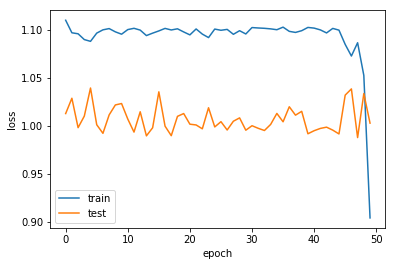

In [35]:
import matplotlib.pyplot as plt

h = k_history[0][8]
# list all data in history
print(h.history.keys())
# summarize history for accuracy
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
# plt.title()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.savefig("z_loss_subj8.png", bbox_inches = 'tight', pad_inches = 0)
plt.show()

dict_keys(['val_loss', 'categorical_accuracy', 'loss', 'val_categorical_accuracy'])


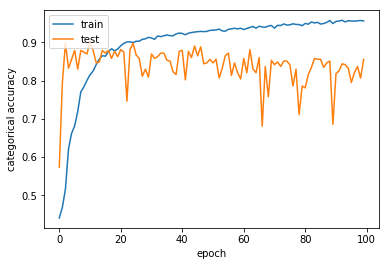

In [80]:
import matplotlib.pyplot as plt

history0 = history[0]

# list all data in history
print(history[1].history.keys())
# summarize history for accuracy
plt.plot(history[8].history['categorical_accuracy'])
plt.plot(history[8].history['val_categorical_accuracy'])
# plt.title('model loss')
plt.ylabel('categorical accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("acc_subj8.png")
plt.show()

In [ ]:
# Get summary statistics of each train/test pairings
## Correct way to do nested LOOCV
# nested LOOCV with the all combis and hyperparameter tuning
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from os import listdir
from os import path
import re
import csv
from keras import backend as K

n_features, n_timesteps = 1, 2

def evaluate_model(trainX, trainy, testX, testy, y_true, model):
#     trainy, testy = trainy[:,0], testy[:,0]
    print('YOOOO')

    epochs, batch_size = 100, 32
    # fit the model
    history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs = epochs, batch_size=batch_size)
    print('FIT')
    # make predictions
    yhat = model.predict_classes(testX, batch_size=batch_size)


    print('PREDICT')
    f1_macro = f1_score(y_true, yhat, average='macro')
    f1 = f1_score(y_true, yhat, average=None)
#     _, accuracy = model.evaluate(testX, testy, verbose=verbose)
    return f1, f1_macro, history

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def create_model():
    clf = Sequential()
    clf.add(LSTM(100, input_shape=(n_timesteps,n_features)))
    clf.add(Dropout(0.5))
    clf.add(Dense(100, activation='relu'))
#     clf.add(Flatten())
    clf.add(Dense(2, activation='softmax'))
    clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1])

    return clf

def run_nested_logo(source, dest, key):    
    global n_features
    global n_timesteps
    
    logo = LeaveOneGroupOut()

    i = 1
    
    done = ['30_15_4', '10_5_1', '5_3_2', '60_30_8', '60_90_0', '5_5_4', '30_45_23',
        '5_5_0', '30_30_8', '60_90_68', '50_100_75', '30_30_15', '60_120_90',
        '10_10_8', '10_20_0', '30_15_0', '60_30_23', '50_25_0', '50_25_6', '30_45_0',
        '5_10_8', '30_15_11']
    
    hist_per_group = list()
    
    for name in listdir(source):
        filename = source + '/' + name
        if not name.endswith('csv') or not name.startswith('total_acc_x_train_'):
            continue
#         pattern = 'total_acc_x_train_' + '[0-9]*[0-9]_[0-9]*[0-9]_[0-9]*[0-9]' + '.csv'
        pattern = 'total_acc_x_train_' + '50_50_38' + '.csv'
        match = re.search(pattern, name)
        if not match:
            continue

        combi = re.search('train_(.+?).csv', name)
        print(combi)
        if combi:
            combi = combi.group(1)
        print(combi)            
            
        print(i, 'out of 79 files')
        print('Reading file', name)
        
        X_all, y_all, subjects = load_dataset(comb=combi, prefix=source)
        for i in range(len(y_all)):
            if y_all[i] == 2:
                y_all[i] = 0
            elif y_all[i] == 3:
                y_all[i] = 1
        # dummy dataset just for logo.split
        X_dummy = np.arange(len(X_all))

#         ind = subjects.index[subjects[0] != 'laura'].tolist()
#         X_dummy = X_dummy[ind]
#         groups = subjects[subjects[0] != 'laura'].iloc[:,0]
#         print(len(groups))
        groups = subjects.iloc[:,0]
#         print(groups)
        
#         train_ind = subjects.index[subjects[0] == 'lenin'].tolist()
#         train_ind.extend(subjects.index[subjects[0] == 'bojan'].tolist())
#         train_ind.extend(subjects.index[subjects[0] == 'sue'].tolist())
#         train_ind.extend(subjects.index[subjects[0] == 'jacob'].tolist())
#         train_ind.extend(subjects.index[subjects[0] == 'dilhan'].tolist())
#         train_ind.extend(subjects.index[subjects[0] == 'miguel'].tolist())
#         train_ind.extend(subjects.index[subjects[0] == 'laura'].tolist())
#         test_ind = subjects.index[subjects[0] == 'daniel'].tolist()
#         test_ind.extend(subjects.index[subjects[0] == 'saeid'].tolist())
#         test_ind.extend(subjects.index[subjects[0] == 'daniel'].tolist())
#         test_ind.extend(subjects.index[subjects[0] == 'miguel'].tolist())
        
#         print(train_ind)
#         print(test_ind)
#         X_train, X_test = X_all[train_ind], X_all[test_ind]
#         y_train, y_test = y_all[train_ind], y_all[test_ind]
        
#         y_train = to_categorical(y_train)
#         y_true = y_test
#         y_test = to_categorical(y_test)

#         n_features = X_train.shape[2]
#         n_timesteps = X_train.shape[1]
        
#         clf = create_model()
        
#         f1, f1_macro, test_history = evaluate_model(X_train, y_train, X_test, y_test, y_true, clf)

#         hist_per_group.append(test_history)
#         print('f1',f1)
#         print('f1_macro', f1_macro)
        
#         results = run_logo(trainX, trainy, subjects.iloc[:,0], X_dummy)

#         all_df = pd.read_csv(filename)

#         X_all = all_df.drop(['state', 'name'], axis=1)
#         y_all = pd.DataFrame(all_df['state'])
#         groups = all_df['name']

        # counting the number of samples per class
#         freq = [0,0,0,0]
#         for val in y_all['state']:
#             freq[val] += 1

#         print('class frequencies', freq)
    
        group = 0
        
        f1s = []
        f1_macros = []
        best_params = []
        best_scores = []
    
        hist_per_group = list()
        for train_index, test_index in logo.split(X_dummy, groups=groups):
#             if group != 2:
#                 group += 1
#                 continue
            X_train, X_test = X_all[train_index], X_all[test_index]
            y_train, y_test = y_all[train_index], y_all[test_index]
                
            y_train = to_categorical(y_train)
            y_true = y_test
            y_test = to_categorical(y_test)
            
            n_features = X_train.shape[2]
            n_timesteps = X_train.shape[1]
            
            print(n_features)
            print(n_timesteps)
#             print(n_outputs)
            
            clf = create_model()
            
            print('OKKKK')
            f1, f1_macro, history = evaluate_model(X_train, y_train, X_test, y_test, y_true, clf)
            print('Group', group)
#             print(grid_obj.best_params_)
            print(f1)
            print('macro', f1_macro)
#             print(grid_obj.best_score_)
            f1s.append(f1)
            f1_macros.append(f1_macro)
#             best_params.append(grid_obj.best_params_)
#             best_scores.append(grid_obj.best_score_)
            
            # Storing history object in list
            hist_per_group.append(history)
#             plt.plot(history.history['loss'])
#             plt.plot(history.history['val_loss'])
#             plt.title('model loss')
#             plt.ylabel('loss')
#             plt.xlabel('epoch')
#             plt.legend(['train', 'test'], loc='upper left')
#             plt.show()
            
            group += 1

# #         header = ['comb']
# #         row = [combi]
        
# #         # create header
# #         for j in range(9):
# #             header.append('f1-0'+'.'+str(j))
# #             header.append('f1-1'+'.'+str(j))
# #             header.append('f1-2'+'.'+str(j))
# #             header.append('f1-3'+'.'+str(j))
# #             header.append('macro'+'.'+str(j))
# #             header.append('best_score_'+'.'+str())
# #             header.append('hyper'+'.'+str(j))
            
# #             row.extend(f1s[j])
# #             row.append(f1_macros[j])
# #             row.append(best_scores[j])
# #             row.append(best_params[j])

# #         outFilename = dest + '/' + key + '.csv'
# #         if not path.isfile(outFilename):
# #             print('creating new file', outFilename)
# #             with open(outFilename, 'w') as outFile:
# #                 writer = csv.writer(outFile)
# #                 writer.writerow(header)
# #                 writer.writerow(row)
# #                 outFile.close()
# #         else:
# #             print('opening existing file', outFilename)
# #             with open(outFilename, 'a+') as outFile:
# #                 writer = csv.writer(outFile)
# #                 writer.writerow(row)
# #                 outFile.close()
#         i += 1
        
    print(np.average(f1_macros))
    print(np.average(f1s, axis=0))
    print(f1_macros)
#     return np.average(f1s, axis=0).tolist(), [np.average(f1_macros).tolist()], [np.average(f1_micros).tolist()], best_params, best_scores
    return hist_per_group

source = '../data/processed/train/keras/done/'
dest = 'results/'

test_history = run_nested_logo(source, dest, 'lstm')